In [1]:
import pickle
import os
import glob
import numpy as np
import json
from scipy.stats import norm

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import defaultdict

In [3]:
path = "/home/jenna/sacro_results/results/"

In [4]:
os.listdir(path)

['cf7cf863-929a-4b89-962b-7913869167e4',
 'a90983a1-2329-4019-96e8-949493c3fc24',
 '315ac662-9e95-4dec-80f0-48e244f9f8e1',
 'b71b28f1-7f63-4593-bdb2-9e60dd1ac71e',
 '96c75293-2026-48af-ad99-37281cb9bb3e',
 '436c714b-b588-4894-b68c-1e0f773e5df1',
 '5238ac7b-ad85-488f-b013-9ee4e2064e60',
 'e8d7e0c4-b293-43ce-832f-c37fb8fd3b23',
 'e6a9f8f7-8024-42d5-aad5-ef726d353f3b',
 '26d9e19b-59ed-4bbb-906a-9953b5d2c825',
 'a3347182-4364-43f8-8992-2409b1b66d31',
 'f63b25f4-8df4-4336-8c02-9456eb3c09b0',
 'slinwin_processor.py',
 'e8d3eabc-edd1-414f-9d95-277df742655a',
 'b6701cb1-3a9b-456e-ad73-c6e06eea03ec']

In [5]:
# load pred and true labels. may use mode_ave for comparison
def getLabels(video):
    example_path = path + video
    pred_labels = pickle.load(open(example_path + "/seq_pred.pickle", 'rb'))
#     mode_ave_pred_labels = pickle.load(open(example_path + "/seq_mode_av.pickle", 'rb'))
    true_labels = pickle.load(open(example_path + "/seq_true.pickle", 'rb'))
    return (pred_labels, true_labels)

In [6]:
# load vanilla and extended PKI models results
pki_res_path = "./jenna_model_outputs/"
os.listdir(pki_res_path)

['vanilla_pki_output.pickle',
 'epdp_output.pickle',
 'eptp_output.pickle',
 'fepp_output.pickle']

In [7]:
# vanilla pki results
pki_output = pickle.load(open(pki_res_path + "vanilla_pki_output.pickle", 'rb'))
# extended pki with duration prior results (transition probability)
epdp_output = pickle.load(open(pki_res_path + "epdp_output.pickle", 'rb'))
# extended pki with transition timestamps prior results (phase entry probability)
eptp_output = pickle.load(open(pki_res_path + "eptp_output.pickle", 'rb'))
# fully extended pki with priors
fepp_output = pickle.load(open(pki_res_path + "fepp_output.pickle", 'rb'))

In [8]:
pki_outputs = {"vanilla":pki_output,
               "epdp":epdp_output, 
               "eptp":eptp_output, 
               "fepp":fepp_output}

In [9]:
## get all pred labels and all true labels by video name
pred_label_dict = {}
true_label_dict = {}
for video in os.listdir(path):
    if video == "slinwin_processor.py":
        continue
    pred_labels, true_labels = getLabels(video)
    pred_label_dict[video] = pred_labels
    true_label_dict[video] = true_labels

In [10]:
print(len(pred_label_dict))
print(len(true_label_dict))

14
14


In [11]:
video_names = []
for video in os.listdir(path):
    if video == "slinwin_processor.py":
        continue
    video_names.append(video)

print(len(video_names))    
print(video_names)


14
['cf7cf863-929a-4b89-962b-7913869167e4', 'a90983a1-2329-4019-96e8-949493c3fc24', '315ac662-9e95-4dec-80f0-48e244f9f8e1', 'b71b28f1-7f63-4593-bdb2-9e60dd1ac71e', '96c75293-2026-48af-ad99-37281cb9bb3e', '436c714b-b588-4894-b68c-1e0f773e5df1', '5238ac7b-ad85-488f-b013-9ee4e2064e60', 'e8d7e0c4-b293-43ce-832f-c37fb8fd3b23', 'e6a9f8f7-8024-42d5-aad5-ef726d353f3b', '26d9e19b-59ed-4bbb-906a-9953b5d2c825', 'a3347182-4364-43f8-8992-2409b1b66d31', 'f63b25f4-8df4-4336-8c02-9456eb3c09b0', 'e8d3eabc-edd1-414f-9d95-277df742655a', 'b6701cb1-3a9b-456e-ad73-c6e06eea03ec']


In [12]:
test_folds = {
    1:["e8d7e0c4-b293-43ce-832f-c37fb8fd3b23", "f63b25f4-8df4-4336-8c02-9456eb3c09b0"],
    2:["cf7cf863-929a-4b89-962b-7913869167e4", "b6701cb1-3a9b-456e-ad73-c6e06eea03ec"],
    3:["315ac662-9e95-4dec-80f0-48e244f9f8e1", "a90983a1-2329-4019-96e8-949493c3fc24"],
    4:["e6a9f8f7-8024-42d5-aad5-ef726d353f3b", "96c75293-2026-48af-ad99-37281cb9bb3e"],
    5:["b71b28f1-7f63-4593-bdb2-9e60dd1ac71e", "a3347182-4364-43f8-8992-2409b1b66d31"],
    6:["5238ac7b-ad85-488f-b013-9ee4e2064e60", "436c714b-b588-4894-b68c-1e0f773e5df1"],
    7:["e8d3eabc-edd1-414f-9d95-277df742655a", "26d9e19b-59ed-4bbb-906a-9953b5d2c825"]
}

In [13]:
### remove zeros in true_labels and the predictions on the corresponding positions
def removeZeros(true_label_dict, pki_outputs):
    true_label_no_zero = {}
    '''
    pki_outputs = {"vanilla":pki_output,
                   "epdp":epdp_output, 
                   "eptp":eptp_output, 
                   "fepp":fepp_output}
    '''
    pki_output_no_zero = {}
    fepp_output_no_zero = {}
    eptp_output_no_zero = {}
    epdp_output_no_zero = {}
    pki_output_dict_no_zero = {"vanilla":pki_output_no_zero,
                               "epdp":epdp_output_no_zero, 
                               "eptp":eptp_output_no_zero, 
                               "fepp":fepp_output_no_zero}

    for video in true_label_dict:
    #     print("Video:"+video)
        true_label = np.asarray(true_label_dict[video])
        # get positions of zeros in ground truth
    #     print("position of zeros:{}".format(zero_pos))
        zero_pos = np.where(true_label==0)[0]
        # remove zeros from true label
        true_label_no_zero[video] = true_label[true_label != 0]

    #     print("Number of frames BEFORE removing zero:{}".format(len(true_label)))
    #     print("Number of phase zero frames:{}".format(len(zero_pos)))
    #     print("Number of frames AFTER removing zero:{}".format(len(true_label_no_zero)))
    #     print("True labels AFTER removing zero:{}".format(true_label_no_zero))

        for model in pki_outputs:
            model_output = np.asarray(pki_outputs[model][video])
            model_output_no_zero = np.delete(model_output,zero_pos)
    #         print("Length of {} outputs after removing zeros:{}".format(model, len(model_output_no_zero)))
            pki_output_dict_no_zero[model][video] = model_output_no_zero
    return (true_label_no_zero, pki_output_dict_no_zero)

In [14]:
true_label_no_zero, pki_output_dict_no_zero = removeZeros(true_label_dict, pki_outputs)

## Evaluation:
**video comparison**: get accuracy and f1 scores (average of per phase) for each video and compare the trend   
**per-phase evaluation**: all metrics are done per phase basis. final score reported for the metrics is the average score for that phase across all videos

In [15]:
# get accuracy across all folds including zeros
num = len(test_folds)
ave_pki_acc = 0
ave_epdp_acc = 0
ave_eptp_acc = 0
ave_fepp_acc = 0

#list to store accuracy for each video for plotting later
pki_acc_list = []
epdp_acc_list = []
eptp_acc_list = []
fepp_acc_list = []

for fold_num in test_folds:
    per_fold_ave_acc_pki = 0
    per_fold_ave_acc_epdp = 0
    per_fold_ave_acc_eptp = 0
    per_fold_ave_acc_fepp = 0
    for video in test_folds[fold_num]:
        true_labels = true_label_dict[video]
        pki_acc =  accuracy_score(true_labels, pki_output[video])
        epdp_acc = accuracy_score(true_labels, epdp_output[video])
        eptp_acc = accuracy_score(true_labels, eptp_output[video])
        fepp_acc = accuracy_score(true_labels, fepp_output[video])
        
        per_fold_ave_acc_pki += pki_acc
        per_fold_ave_acc_epdp += epdp_acc
        per_fold_ave_acc_eptp += eptp_acc
        per_fold_ave_acc_fepp += fepp_acc
        
    # get per fold average
    per_fold_ave_acc_pki /= 2
    per_fold_ave_acc_epdp /= 2
    per_fold_ave_acc_eptp /= 2
    per_fold_ave_acc_fepp /= 2
    
    pki_acc_list.append(per_fold_ave_acc_pki)
    epdp_acc_list.append(per_fold_ave_acc_epdp)
    eptp_acc_list.append(per_fold_ave_acc_eptp)    
    fepp_acc_list.append(per_fold_ave_acc_fepp)
    
    
    ave_pki_acc += per_fold_ave_acc_pki
    ave_epdp_acc += per_fold_ave_acc_epdp
    ave_eptp_acc += per_fold_ave_acc_eptp
    ave_fepp_acc += per_fold_ave_acc_fepp
    
    print("Test fold {}:".format(fold_num))
    print("PKI acc: {}".format(per_fold_ave_acc_pki))
    print("EPDP acc: {}".format(per_fold_ave_acc_epdp))
    print("EPTP acc: {}".format(per_fold_ave_acc_eptp))
    print("FEPP acc: {}".format(per_fold_ave_acc_fepp))
    print()
    
acc_list = [pki_acc_list, epdp_acc_list, eptp_acc_list, fepp_acc_list]
models = ["Vanilla PKI", "EPDP", "EPTP", "FEPP"]
for i in range(4):
    print(acc_list[i])
    mu, sig = norm.fit(acc_list[i])
    print("Model {} has average acc of {} +/- {}".format(models[i], mu*100, sig*100))

Test fold 1:
PKI acc: 0.7925130077590141
EPDP acc: 0.7595381104518485
EPTP acc: 0.8495572797809219
FEPP acc: 0.8349465997261525

Test fold 2:
PKI acc: 0.7807715322001036
EPDP acc: 0.8307849036420465
EPTP acc: 0.8021093449664878
FEPP acc: 0.8064980193551622

Test fold 3:
PKI acc: 0.7419087185918442
EPDP acc: 0.78419707674911
EPTP acc: 0.8164828375105929
FEPP acc: 0.8291359592392517

Test fold 4:
PKI acc: 0.6678062601225565
EPDP acc: 0.7041154535686049
EPTP acc: 0.773223327196515
FEPP acc: 0.78269399467133

Test fold 5:
PKI acc: 0.7645499817373564
EPDP acc: 0.7959816016715286
EPTP acc: 0.8286443225107469
FEPP acc: 0.8323016481607497

Test fold 6:
PKI acc: 0.7772156445376874
EPDP acc: 0.8265606935531435
EPTP acc: 0.793803195315904
FEPP acc: 0.8098708465434078

Test fold 7:
PKI acc: 0.8027526493886772
EPDP acc: 0.8703939558894618
EPTP acc: 0.7887899451353886
FEPP acc: 0.8071064284813958

[0.7925130077590141, 0.7807715322001036, 0.7419087185918442, 0.6678062601225565, 0.7645499817373564, 0.

In [120]:
# get accuracy across all folds excluding zeros
def getAccNoZero(pki_output_dict_no_zero):
    num = len(test_folds)
    ave_pki_acc = 0
    ave_epdp_acc = 0
    ave_eptp_acc = 0
    ave_fepp_acc = 0

    #list to store accuracy for each video for plotting later
    pki_acc_list = []
    epdp_acc_list = []
    eptp_acc_list = []
    fepp_acc_list = []

    for fold_num in test_folds:
        per_fold_ave_acc_pki = 0
        per_fold_ave_acc_epdp = 0
        per_fold_ave_acc_eptp = 0
        per_fold_ave_acc_fepp = 0
        for video in test_folds[fold_num]:
            true_labels = true_label_no_zero[video]
            pki_acc =  accuracy_score(true_labels, pki_output_dict_no_zero["vanilla"][video])
            epdp_acc = accuracy_score(true_labels, pki_output_dict_no_zero["epdp"][video])
            eptp_acc = accuracy_score(true_labels, pki_output_dict_no_zero["eptp"][video])
            fepp_acc = accuracy_score(true_labels, pki_output_dict_no_zero["fepp"][video])

            per_fold_ave_acc_pki += pki_acc
            per_fold_ave_acc_epdp += epdp_acc
            per_fold_ave_acc_eptp += eptp_acc
            per_fold_ave_acc_fepp += fepp_acc

        # get per fold average
        per_fold_ave_acc_pki /= 2
        per_fold_ave_acc_epdp /= 2
        per_fold_ave_acc_eptp /= 2
        per_fold_ave_acc_fepp /= 2

        pki_acc_list.append(per_fold_ave_acc_pki)
        epdp_acc_list.append(per_fold_ave_acc_epdp)
        eptp_acc_list.append(per_fold_ave_acc_eptp)    
        fepp_acc_list.append(per_fold_ave_acc_fepp)


        ave_pki_acc += per_fold_ave_acc_pki
        ave_epdp_acc += per_fold_ave_acc_epdp
        ave_eptp_acc += per_fold_ave_acc_eptp
        ave_fepp_acc += per_fold_ave_acc_fepp

#         print("Test fold {}:".format(fold_num))
#         print("PKI acc: {}".format(per_fold_ave_acc_pki))
#         print("EPDP acc: {}".format(per_fold_ave_acc_epdp))
#         print("EPTP acc: {}".format(per_fold_ave_acc_eptp))
#         print("FEPP acc: {}".format(per_fold_ave_acc_fepp))
#         print()

    acc_list = [pki_acc_list, epdp_acc_list, eptp_acc_list, fepp_acc_list]
    models = ["Vanilla PKI", "EPDP", "EPTP", "FEPP"]
    for i in range(4):
#         print(acc_list[i])
        mu, sig = norm.fit(acc_list[i])
        print("Model {} has average acc of {} +/- {}".format(models[i], mu*100, sig*100))
        print()

In [121]:
getAccNoZero(pki_output_dict_no_zero)

Model Vanilla PKI has average acc of 82.40774551946373 +/- 5.189203257356418

Model EPDP has average acc of 82.76358090425569 +/- 5.406278871948072

Model EPTP has average acc of 86.02266275714437 +/- 3.082511868524433

Model FEPP has average acc of 86.38519964945715 +/- 2.893597351210096



In [154]:
from matplotlib import rcParams

# figure size in inches
rcParams['font.size'] = 20
rcParams['legend.fontsize']= 20
rcParams['xtick.labelsize']= 20
rcParams['ytick.labelsize']= 20

In [19]:
from math import log10, floor
def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))


<Figure size 1080x576 with 0 Axes>

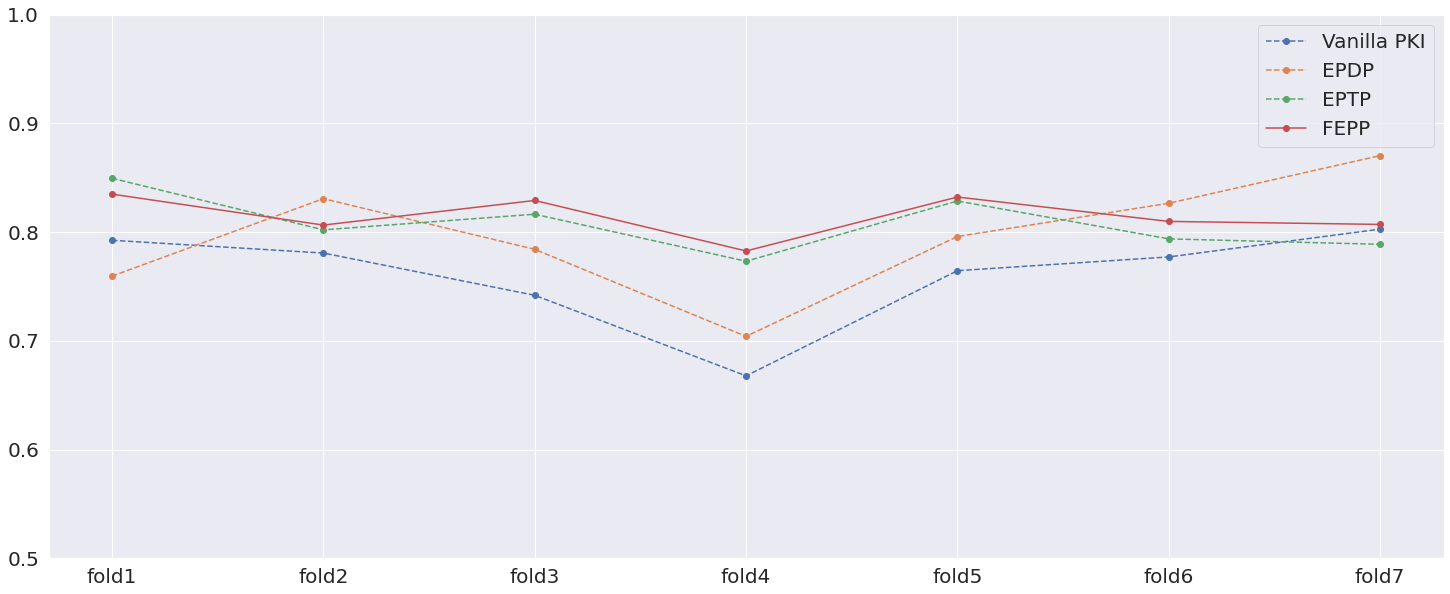

In [156]:
# plot for the accuracies across videos
##############
num = len(test_folds)
figure(figsize=(15, 8))
x = list(range(1, num+1, 1))
plt.figure(figsize=(25, 10))
plt.rc('font', size=25)
labels = ["fold{}".format(i) for i in range(1,8)]
plt.xticks(x, labels=labels)  # Set label locations.
plt.ylim(ymin=0.5)
plt.plot(x, pki_acc_list, '--o',label="Vanilla PKI")
plt.plot(x, epdp_acc_list,'--o', label="EPDP")
plt.plot(x, eptp_acc_list,'--o', label="EPTP")
plt.plot(x, fepp_acc_list,'-o', label="FEPP")
# for i in range(len(x)):
#     plt.text(i,pki_acc_list[i], round_to_1(pki_acc_list[i]))
#     plt.text(i,epdp_acc_list[i],round_to_1(epdp_acc_list[i]))
#     plt.text(i,eptp_acc_list[i],round_to_1(eptp_acc_list[i]))
#     plt.text(i,fepp_acc_list[i], round_to_1(fepp_acc_list[i]))
plt.legend()
plt.show()

In [21]:
# Now, you need to loop through every video and document the label list and label freq
# Put above code into function
def get_label_list_and_freq(full_path):
#     pred_labels = pickle.load(open(full_path + "/seq_pred.pickle", 'rb'))
    true_labels = pickle.load(open(full_path + "/seq_true.pickle", 'rb'))
    # scan through the true labels to see whether there are early phases repeating in the later stage
    labels_list = []
    labels_freq = []
    for current_label in true_labels:
        #if list is empty or current label is not the same as the previous label, 
        #then append the current label and frequency
        if (not labels_list) or (current_label != labels_list[-1]):
            labels_list.append(current_label)
            labels_freq.append(1)
            continue
        # for the other cases, simply update frequency
        labels_freq[-1] += 1
    return (labels_list, labels_freq)


# Loop through the subdirectory and extract the label lists and frequencies
data_dict = {}
for subdir in video_names:
    full_path = path + subdir
    labels_list, labels_freq = get_label_list_and_freq(full_path)
    # store the list and corresponding frequency into a dictionary
    labels_dict = {}
    labels_dict["label list"] = labels_list
    labels_dict["label freq"] = labels_freq
    # store the label dictionary into the data dictionary under the corresponding subdirectory
    data_dict[subdir] = labels_dict
    
for vid in data_dict:
    print("{}:".format(vid))
    print("label list:{}\nlabel freq:{}".format(data_dict[vid]["label list"], data_dict[vid]["label freq"]))

cf7cf863-929a-4b89-962b-7913869167e4:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[169, 8, 593, 12, 455, 1, 24, 6, 344, 9, 192]
a90983a1-2329-4019-96e8-949493c3fc24:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 5]
label freq:[41, 16, 334, 106, 476, 4, 7, 22, 120]
315ac662-9e95-4dec-80f0-48e244f9f8e1:
label list:[1, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[84, 231, 23, 544, 24, 26, 39, 192, 7, 184]
b71b28f1-7f63-4593-bdb2-9e60dd1ac71e:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[47, 3, 846, 1, 394, 3, 23, 10, 143, 2, 109]
96c75293-2026-48af-ad99-37281cb9bb3e:
label list:[2, 1, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[146, 101, 254, 17, 550, 1, 73, 14, 190, 15, 266]
436c714b-b588-4894-b68c-1e0f773e5df1:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[153, 45, 348, 39, 346, 2, 51, 17, 221, 10, 131]
5238ac7b-ad85-488f-b013-9ee4e2064e60:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 5]
label freq:[54, 1, 728, 28, 379, 14, 21, 62, 151]
e8d7e0c4-b293-43ce-832f-c37fb8fd3b23:
label l

In [22]:
a = np.asarray([1,1,1,1,0,0,0,2,2,2,2,2,2,2])
zero_pos = np.where(a==0)
print(zero_pos)
b = np.asarray([1,1,1,1,5,5,5,5,5,2,2,2,2,2])
np.delete(b,zero_pos)

(array([4, 5, 6]),)


array([1, 1, 1, 1, 5, 5, 2, 2, 2, 2, 2])

## Get multi-class confusion matrix

In [23]:
# one confusion matrix per model
cm_dict = {}
for model in pki_output_dict_no_zero:
    cm = np.array([[0.0]*5]*5)
    phase_count = [0]*5
    model_pred_dict = pki_output_dict_no_zero[model]
    for video in model_pred_dict:
        y_pred = model_pred_dict[video]
        y_true = true_label_no_zero[video]
        for i in range(len(y_true)):
            phase_count[y_true[i]-1] += 1
            cm[y_true[i]-1][y_pred[i]-1] += 1
    # normalise cm by the phase_count
    for i in range(len(phase_count)):
        cm[i] = cm[i]/ phase_count[i]
    # attach it to the dict
    cm_dict[model] = cm
    
print(cm_dict)

{'vanilla': array([[0.71450151, 0.24622356, 0.        , 0.        , 0.03927492],
       [0.11694291, 0.84054635, 0.00521793, 0.01304481, 0.024248  ],
       [0.        , 0.04045369, 0.83944549, 0.04713296, 0.07296786],
       [0.04269663, 0.10561798, 0.24719101, 0.56404494, 0.04044944],
       [0.        , 0.09894156, 0.15876668, 0.01196503, 0.73032674]]), 'epdp': array([[6.11027190e-01, 3.77643505e-01, 4.53172205e-03, 0.00000000e+00,
        6.79758308e-03],
       [4.86494782e-02, 9.26949048e-01, 1.62676489e-02, 7.36648250e-03,
        7.67341928e-04],
       [0.00000000e+00, 2.55828607e-02, 9.02205419e-01, 1.58790170e-02,
        5.63327032e-02],
       [4.49438202e-03, 1.03370787e-01, 6.06741573e-01, 2.22471910e-01,
        6.29213483e-02],
       [0.00000000e+00, 1.05844455e-01, 2.08007363e-01, 4.60193281e-04,
        6.85687989e-01]]), 'eptp': array([[0.76057402, 0.23942598, 0.        , 0.        , 0.        ],
       [0.106814  , 0.8364027 , 0.0567833 , 0.        , 0.        ],


In [24]:
from matplotlib import rcParams
rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [25]:
# ### get confusion matrix for 6 phases
# # one confusion matrix per model
# cm_dict = {}
# for model in pki_outputs:
#     cm = np.array([[0.0]*6]*6)
#     phase_count = [0]*6
#     model_pred_dict = pki_outputs[model]
#     for video in model_pred_dict:
#         y_pred = model_pred_dict[video]
#         y_true = true_label_no_zero[video]
#         for i in range(len(y_true)):
#             phase_count[y_true[i]] += 1
#             cm[y_true[i]][y_pred[i]] += 1
#     # normalise cm by the phase_count
#     for i in range(len(phase_count)):
#         cm[i] = cm[i]/ phase_count[i]
#     # attach it to the dict
#     cm_dict[model] = cm
    
# print(cm_dict)

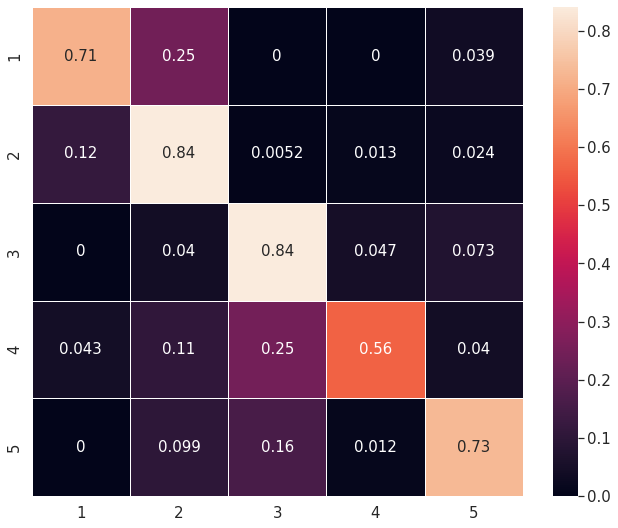

In [26]:
# plot heat map for confusion matrix for each model
import seaborn as sns; sns.set_theme()
# fig = plt.figure(figsize = (20,20)) # width x height
# ax1 = fig.add_subplot(2, 2, 1) # row, column, position
# ax2 = fig.add_subplot(2, 2, 2)
# ax3 = fig.add_subplot(2, 2, 3)
# ax4 = fig.add_subplot(2, 2, 4)
sns.set(rc={'figure.figsize':(11,9),
            'font.size':15,
            'xtick.labelsize': 15.0,
            'ytick.labelsize': 15.0,
            'axes.titlesize': 15.0,

           })
ax = sns.heatmap(cm_dict["vanilla"],  linewidths=.5, annot=True,  xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.savefig("cm_vanilla", bbox_inches='tight')

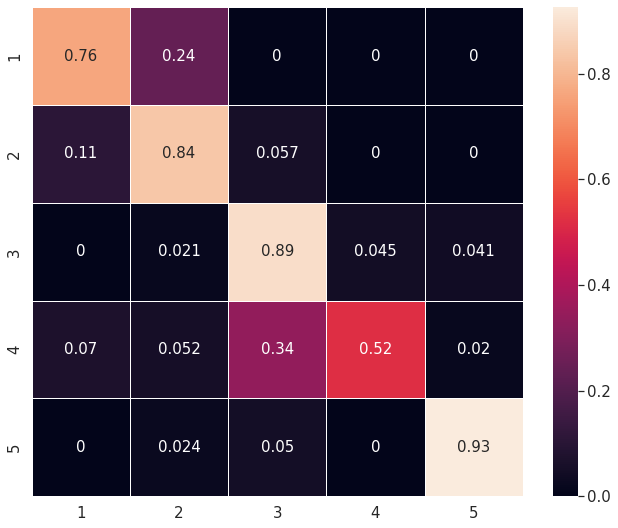

In [27]:
# plot heat map for confusion matrix for each model
import seaborn as sns; sns.set_theme()
# fig = plt.figure(figsize = (20,20)) # width x height
# ax1 = fig.add_subplot(2, 2, 1) # row, column, position
# ax2 = fig.add_subplot(2, 2, 2)
# ax3 = fig.add_subplot(2, 2, 3)
# ax4 = fig.add_subplot(2, 2, 4)
sns.set(rc={'figure.figsize':(11,9),
            'font.size':15,
            'xtick.labelsize': 15.0,
            'ytick.labelsize': 15.0,
            'axes.titlesize': 15.0,

           })
ax = sns.heatmap(cm_dict["eptp"],  linewidths=.5, annot=True,  xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.savefig("cm_eptp", bbox_inches='tight')

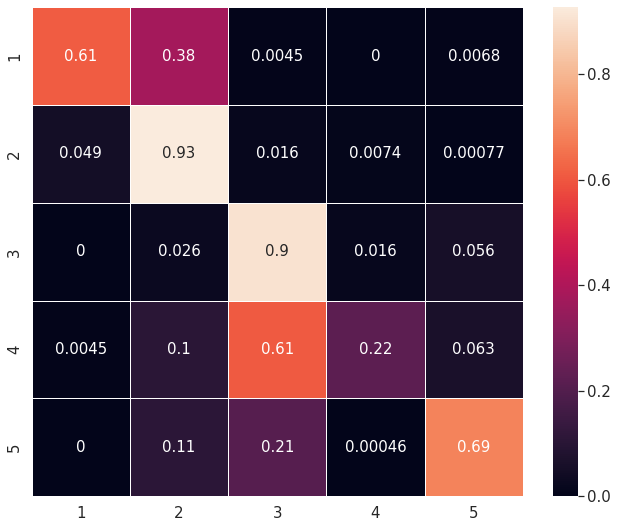

In [28]:
# plot heat map for confusion matrix for each model
import seaborn as sns; sns.set_theme()
# fig = plt.figure(figsize = (20,20)) # width x height
# ax1 = fig.add_subplot(2, 2, 1) # row, column, position
# ax2 = fig.add_subplot(2, 2, 2)
# ax3 = fig.add_subplot(2, 2, 3)
# ax4 = fig.add_subplot(2, 2, 4)
sns.set(rc={'figure.figsize':(11,9),
            'font.size':15,
            'xtick.labelsize': 15.0,
            'ytick.labelsize': 15.0,
            'axes.titlesize': 15.0,

           })
ax = sns.heatmap(cm_dict["epdp"],  linewidths=.5, annot=True,  xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.savefig("cm_epdp", bbox_inches='tight')

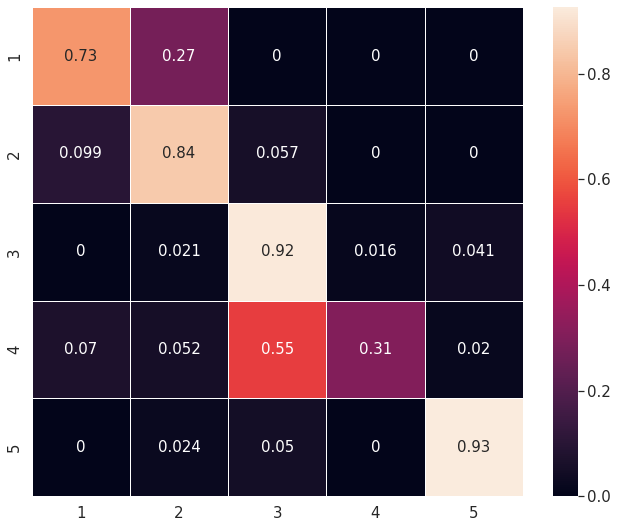

In [29]:
# plot heat map for confusion matrix for each model
import seaborn as sns; sns.set_theme()
# fig = plt.figure(figsize = (20,20)) # width x height
# ax1 = fig.add_subplot(2, 2, 1) # row, column, position
# ax2 = fig.add_subplot(2, 2, 2)
# ax3 = fig.add_subplot(2, 2, 3)
# ax4 = fig.add_subplot(2, 2, 4)
sns.set(rc={'figure.figsize':(11,9),
            'font.size':15,
            'xtick.labelsize': 15.0,
            'ytick.labelsize': 15.0,
            'axes.titlesize': 15.0,

           })
ax = sns.heatmap(cm_dict["fepp"],  linewidths=.5, annot=True,  xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.savefig("cm_fepp", bbox_inches='tight')

In [30]:
### metrics: per-phase accuracy, per-phase f1 score, per-phase confusion matrix(?) for each model
def evalScorePerPhase(model_output_dict, true_label_dict, data_dict, metric, is_verbose=False):
    scores_dict = {}
    for vid in data_dict:
        if is_verbose:
            print("Video {}".format(vid))
        # add a new default dict for each video to store the per_phase score
        phases_scores = {}

        # get the labels
        true_label = np.asarray(true_label_dict[vid])
        model_output = np.asarray(model_output_dict[vid])
        
        ## storage
        per_phase_f1_score = []
        cur_i = 0
        
#         # use ground truth to separate the phases
#         phases = data_dict[vid]["label list"]
#         nums_of_frames = data_dict[vid]["label freq"]
        
        # loop through each phase and get the accuracy and f1 score
        # for each phase, keep only the phases and changes everything else to a non-phase value
#         for i, phase in enumerate(phases):            
        for phase in range(1, 6):
            phase_true_label = np.where(true_label!=phase, -1, true_label)
            phase_model_output = np.where(model_output!=phase, -1, model_output)

            # change all non-phase values in the prediction results to -1 for binary f1 scoring
#             phase_model_output = np.where(phase_model_output!=phase, -1, phase_model_output)
            if is_verbose and vid == "96c75293-2026-48af-ad99-37281cb9bb3e":
                print("Phase:{}".format(phase))
#                 print("Number of frames for phase {} is {}".format(phase, nums_of_frames[i]))
#                 print("Current index marker:{}".format(cur_i))
                print("True labels:\n {}".format(phase_true_label.tolist()))
#                 print("This is just for checking the index correctness:{}".format(true_label[cur_i-1:cur_i+nums_of_frames[i]+1]))
                print("Model output:\n {}".format(phase_model_output.tolist()))
                print()
            score = 0
            if metric == "f1":
                score = f1_score(phase_true_label, phase_model_output, pos_label=phase, zero_division=0)
            if metric == "precision":
                score = precision_score(phase_true_label, phase_model_output, pos_label=phase, zero_division=0)
            if metric == "recall":
                score = recall_score(phase_true_label, phase_model_output, pos_label=phase, zero_division=0)
#             if metric == "acc":
#                 score = accuracy_score(phase_true_label, phase_model_output)
                
#             print("Phase {} f1 score = {}".format(phase, f1))
#             print()

            # get the average metric value and add it to the dict
            if phase in phases_scores:
                phases_scores[phase] = (phases_scores[phase] + score)/2
            else:
                phases_scores[phase] = score
                
#             cur_i += nums_of_frames[i]

        # add the dict under the video name
        scores_dict[vid] = phases_scores
    return scores_dict

In [31]:
def printPhaseMetricScores(scores):
    for vid in scores:
        print("{}:".format(vid))
        print("phase metric scores:{}".format(scores[vid]))
        print()

In [32]:
# testing: evaluate per-phase f1 score for vanilla pki output
f1_score_vanilla_pki = evalScorePerPhase(pki_output_dict_no_zero["vanilla"], true_label_no_zero, data_dict, "f1", is_verbose=False)
printPhaseMetricScores(f1_score_vanilla_pki)

cf7cf863-929a-4b89-962b-7913869167e4:
phase metric scores:{1: 0.5571428571428572, 2: 0.8602999210734017, 3: 0.8958475153165418, 4: 0.3404255319148936, 5: 0.6936936936936937}

a90983a1-2329-4019-96e8-949493c3fc24:
phase metric scores:{1: 0.6391752577319588, 2: 0.8831168831168831, 3: 0.9055374592833877, 4: 0.0, 5: 0.802675585284281}

315ac662-9e95-4dec-80f0-48e244f9f8e1:
phase metric scores:{1: 0.8876404494382023, 2: 0.7833698030634574, 3: 0.8392156862745098, 4: 0.9056603773584906, 5: 0.6511627906976744}

b71b28f1-7f63-4593-bdb2-9e60dd1ac71e:
phase metric scores:{1: 0.810344827586207, 2: 0.9657210401891253, 3: 0.9302769818529131, 4: 0.37037037037037035, 5: 0.9209302325581395}

96c75293-2026-48af-ad99-37281cb9bb3e:
phase metric scores:{1: 0.47572815533980584, 2: 0.753103448275862, 3: 0.8290535583272193, 4: 0.6727272727272727, 5: 0.6005291005291005}

436c714b-b588-4894-b68c-1e0f773e5df1:
phase metric scores:{1: 0.7560975609756097, 2: 0.8810126582278481, 3: 0.8968036529680365, 4: 0.64462809

In [33]:
# get the average f1 score for each phase for the given model output
# only for five non-transition phases here
def getAveScoreAcrossAllFolds(vid2ScoresDict, test_folds):
    ave_per_fold_score_dict = {}
    for fold_num in test_folds:
        scores = np.asarray([0.0]*5)
        count_phases = np.asarray([0.0]*5)
        # get average value for each fold
        for video in test_folds[fold_num]:
            score_dict = vid2ScoresDict[video]
            for phase in range(1, 6):
                if phase in score_dict:
                    count_phases[phase-1] += 1
                    scores[phase-1] += score_dict[phase]
        scores /= count_phases
        ave_per_fold_score_dict[fold_num] = scores
#     print(scores)
#     print(count_phases)

    return ave_per_fold_score_dict

In [34]:
# test: get average f1 score for vanilla pki output
f1_ave_scores = getAveScoreAcrossAllFolds(f1_score_vanilla_pki, test_folds)
print(f1_ave_scores)

{1: array([0.47022521, 0.84517045, 0.90986173, 0.64725644, 0.68119772]), 2: array([0.5472583 , 0.83361904, 0.92108915, 0.457884  , 0.81792123]), 3: array([0.76340785, 0.83324334, 0.87237657, 0.45283019, 0.72691919]), 4: array([0.59807913, 0.8097395 , 0.75317926, 0.42101972, 0.59785168]), 5: array([0.44683908, 0.74030733, 0.89953213, 0.18518519, 0.46046512]), 6: array([0.57159717, 0.86349483, 0.92609212, 0.57231405, 0.83771542]), 7: array([0.64817205, 0.85582634, 0.91712003, 0.5625    , 0.4192229 ])}


In [35]:
f1_ave_scores_mat = np.asarray(list(f1_ave_scores.values()))
f1_ave_scores_mat

array([[0.47022521, 0.84517045, 0.90986173, 0.64725644, 0.68119772],
       [0.5472583 , 0.83361904, 0.92108915, 0.457884  , 0.81792123],
       [0.76340785, 0.83324334, 0.87237657, 0.45283019, 0.72691919],
       [0.59807913, 0.8097395 , 0.75317926, 0.42101972, 0.59785168],
       [0.44683908, 0.74030733, 0.89953213, 0.18518519, 0.46046512],
       [0.57159717, 0.86349483, 0.92609212, 0.57231405, 0.83771542],
       [0.64817205, 0.85582634, 0.91712003, 0.5625    , 0.4192229 ]])

In [36]:
f1_ave_all_folds = np.sum(f1_ave_scores_mat, axis=0)/len(f1_ave_scores_mat)
f1_ave_all_folds

array([0.57793983, 0.8259144 , 0.88560728, 0.47128423, 0.64875618])

In [37]:
f1_one_val_ave = np.sum(f1_ave_all_folds)/len(f1_ave_all_folds)
f1_one_val_ave

0.6819003844180496

In [38]:
# get average score for each phase across all videos (vector length: 5)
def getAveScoreAcrossAllVid(ave_scores_dict):
    ave_scores_mat = np.asarray(list(ave_scores_dict.values()))
    ave_all_folds = np.sum(ave_scores_mat, axis=0)/len(ave_scores_mat)
    return ave_all_folds

In [39]:
# get average score by fold (vector length: 7)
def getAveScoreByFold(ave_scores_dict):
    ave_scores_mat = np.asarray(list(ave_scores_dict.values()))
#     print("SUM OF SCORES BY FOLD:")
#     print(np.sum(ave_scores_mat, axis=1))
    ave = np.sum(ave_scores_mat, axis=1)/5
    return ave

In [40]:
def printPerFoldAveScores(perFoldScoreDict):
    for fold in perFoldScoreDict:
        print("Fold {}:".format(fold))
        print("Score:{}".format(perFoldScoreDict[fold]))

## Get F1 scores for all four model outputs AND an average across all phases

In [41]:
for model_output_name in pki_outputs:
    f1_scores = evalScorePerPhase(pki_output_dict_no_zero[model_output_name], true_label_no_zero, data_dict, "f1")
#     print(f1_scores)
    # get per-fold average scores
    f1_ave_scores_dict = getAveScoreAcrossAllFolds(f1_scores, test_folds)
    # get average by phase (vector length: 5)
    f1_ave_scores = getAveScoreAcrossAllVid(f1_ave_scores_dict)
    # get average by fold (vector length: 7)
    f1_ave_scores_by_fold = getAveScoreByFold(f1_ave_scores_dict)


    print("Current model:{}".format(model_output_name))
    print("Per fold F1 socres:")
    printPerFoldAveScores(f1_ave_scores_dict)
    print("f1 average scores for individual phase:\n{}".format(f1_ave_scores))
    print("f1 average scores by fold:\n{}".format(f1_ave_scores_by_fold))
    print("Average f1 score across all videos all phases:{}".format(np.sum(f1_ave_scores)/len(f1_ave_scores)))
    print()


Current model:vanilla
Per fold F1 socres:
Fold 1:
Score:[0.47022521 0.84517045 0.90986173 0.64725644 0.68119772]
Fold 2:
Score:[0.5472583  0.83361904 0.92108915 0.457884   0.81792123]
Fold 3:
Score:[0.76340785 0.83324334 0.87237657 0.45283019 0.72691919]
Fold 4:
Score:[0.59807913 0.8097395  0.75317926 0.42101972 0.59785168]
Fold 5:
Score:[0.44683908 0.74030733 0.89953213 0.18518519 0.46046512]
Fold 6:
Score:[0.57159717 0.86349483 0.92609212 0.57231405 0.83771542]
Fold 7:
Score:[0.64817205 0.85582634 0.91712003 0.5625     0.4192229 ]
f1 average scores for individual phase:
[0.57793983 0.8259144  0.88560728 0.47128423 0.64875618]
f1 average scores by fold:
[0.71074231 0.71555434 0.72975543 0.63597386 0.54646577 0.75424272
 0.68056827]
Average f1 score across all videos all phases:0.6819003844180496

Current model:epdp
Per fold F1 socres:
Fold 1:
Score:[0.37482068 0.85025539 0.87255629 0.33289474 0.47968464]
Fold 2:
Score:[0.76559908 0.88717014 0.91229193 0.14655172 0.76354167]
Fold 3:
Sc

## Get PRECISION score for all four model outputs AND an average across all phases

In [111]:
def getPrecisionForAll(pki_output_dict_no_zero):
    precision_scores = {}
    precisions_by_fold = {}
    for model_output_name in pki_outputs:
        scores = evalScorePerPhase(pki_output_dict_no_zero[model_output_name], true_label_no_zero, data_dict, "precision")
    #     printPhaseMetricScores(scores)
        # get per fold precision score
        ave_scores_dict = getAveScoreAcrossAllFolds(scores, test_folds)
        # get average score across all folds
        ave_scores = getAveScoreAcrossAllVid(ave_scores_dict)
        # get average by fold (vector length: 7)
        ave_scores_by_fold = getAveScoreByFold(ave_scores_dict)


        # store
        precision_scores[model_output_name] = ave_scores_dict
        precisions_by_fold[model_output_name] = ave_scores_by_fold

        # print
        print("Current model:{}".format(model_output_name))
#         print("Per fold precision socres:")
#         printPerFoldAveScores(ave_scores_dict)
#         print("Average precision scores for individual phase:\n{}".format(ave_scores))
#         print("Average precision scores BY FOLD:\n{}".format(ave_scores_by_fold))
        # get mean and std for the score
        mu, sig = norm.fit(ave_scores_by_fold)
        print("Model {} has average score of {} +/- {}".format(model_output_name, mu*100, sig*100))
        print()

    print(precision_scores)
    return (precision_scores, precisions_by_fold)

In [43]:
precision_scores, precisions_by_fold = getPrecisionForAll(pki_output_dict_no_zero)

Current model:vanilla
Average precision scores for individual phase:
[0.54997044 0.83804411 0.92819772 0.54814124 0.64120399]
Average precision scores BY FOLD:
[0.80763092 0.73157761 0.71248422 0.69078072 0.51458588 0.81735983
 0.63336134]
Model vanilla has average score of 70.11115006445134 +/- 9.666303811014938

Current model:epdp
Average precision scores for individual phase:
[0.72079321 0.84064311 0.8998811  0.57493011 0.69801621]
Average precision scores BY FOLD:
[0.80861794 0.7626099  0.75985484 0.66308081 0.61241627 0.8904497
 0.7309398 ]
Model epdp has average score of 74.68527505783824 +/- 8.468133007771833

Current model:eptp
Average precision scores for individual phase:
[0.59775547 0.88748409 0.92875782 0.37585642 0.83259201]
Average precision scores BY FOLD:
[0.84101122 0.75127577 0.76437306 0.71177498 0.65416276 0.75931444
 0.58951191]
Model eptp has average score of 72.44891629137273 +/- 7.599318697596019

Current model:fepp
Average precision scores for individual phase:

In [44]:
# plots
def plot(score_by_fold):
##############
    names = {"vanilla":"Vanilla PKI",
             "eptp":"EPTP",
             "epdp":"EPDP",
             "fepp":"FEPP",
            }
    num = 7
    figure(figsize=(15, 8))
    x = list(range(1, num+1, 1))
    plt.figure(figsize=(25, 12))
    plt.rc('font', size=20)
    labels = ["fold{}".format(i) for i in range(1,8)]
    plt.xticks(x, labels=labels)  # Set label locations.
    plt.ylim(ymin=0.5)
    for model in score_by_fold:
        if model == "fepp":
            plt.plot(x, score_by_fold[model], '-o',label=names[model])
            continue
        plt.plot(x, score_by_fold[model], '--o',label=names[model])
    plt.legend()
    plt.show()

<Figure size 1080x576 with 0 Axes>

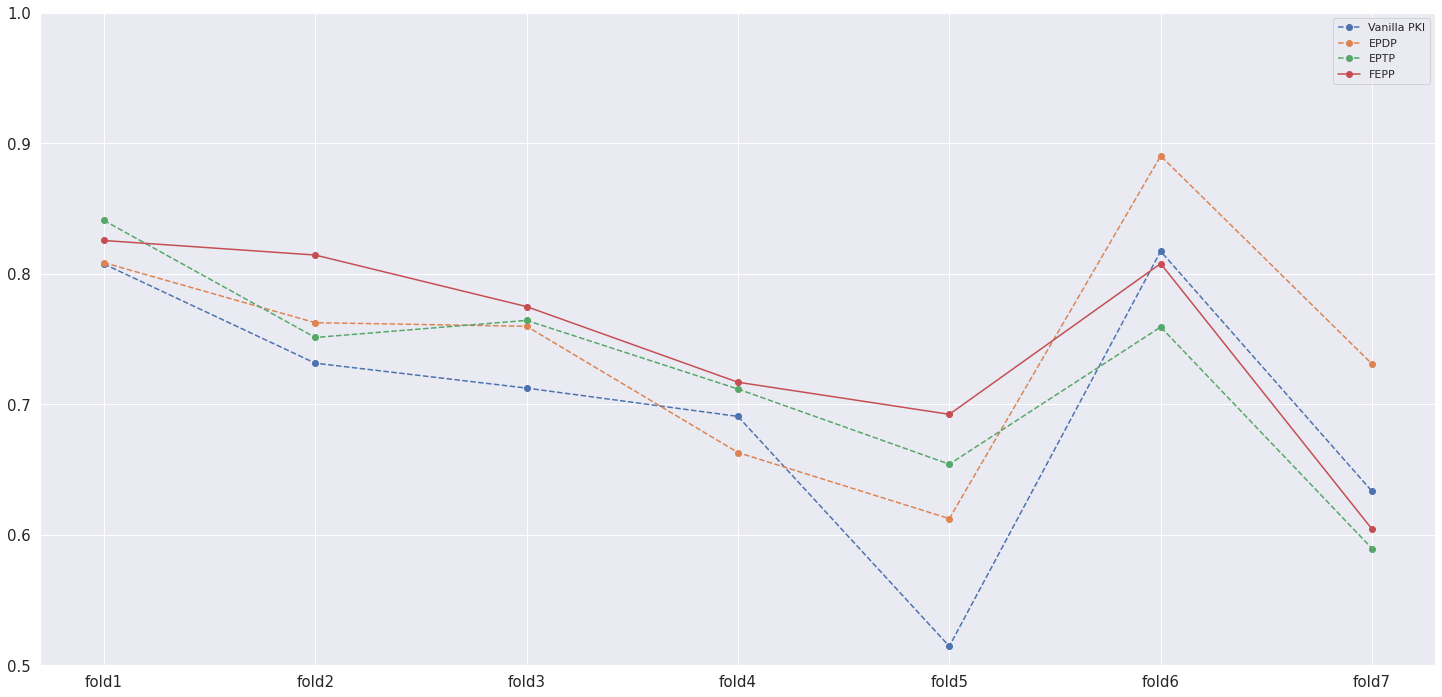

In [45]:
plot(precisions_by_fold)

## Get RECALL score for all four model outputs AND an average across all phases


In [112]:
def getRecallForAll(pki_output_dict_no_zero):
    recall_scores = {}
    recalls_by_fold = {}
    for model_output_name in pki_outputs:
        scores = evalScorePerPhase(pki_output_dict_no_zero[model_output_name], true_label_no_zero, data_dict, "recall")
        # get per fold precision score
        ave_scores_dict = getAveScoreAcrossAllFolds(scores, test_folds)
        # get average score across all folds
        ave_scores = getAveScoreAcrossAllVid(ave_scores_dict)
         # get average by fold (vector length: 7)
        ave_scores_by_fold = getAveScoreByFold(ave_scores_dict)


        # store
        recall_scores[model_output_name] = ave_scores_dict
        recalls_by_fold[model_output_name] = ave_scores_by_fold

        # print
        print("Current model:{}".format(model_output_name))
#         print("Per fold recall socres:")
#         printPerFoldAveScores(ave_scores_dict)
#         print("Average recall scores for individual phase:\n{}".format(ave_scores))
#         print("Average recall scores BY FOLD:\n{}".format(ave_scores_by_fold))
        # get mean and std for the score
        mu, sig = norm.fit(ave_scores_by_fold)
        print("Model {} has average score of {} +/- {}".format(model_output_name, mu*100, sig*100))
        print()


    print(recall_scores)
    return (recall_scores, recalls_by_fold)

In [49]:
recall_scores, recalls_by_fold = getRecallForAll(pki_output_dict_no_zero)

Current model:vanilla
Average recall scores for individual phase:
[0.73075995 0.8457332  0.85171446 0.57360231 0.70106036]
Average recall scores BY FOLD:
[0.71446107 0.76924673 0.78009967 0.69084962 0.6113975  0.7896038
 0.82836001]
Model vanilla has average score of 74.05740579613251 +/- 6.796603899301756

Current model:epdp
Average recall scores for individual phase:
[0.65464991 0.926143   0.91102654 0.26857896 0.65195086]
Average recall scores BY FOLD:
[0.56369539 0.67936799 0.76820721 0.60587622 0.56666214 0.78170044
 0.81177959]
Model epdp has average score of 68.24698545537204 +/- 9.806238277488754

Current model:eptp
Average recall scores for individual phase:
[0.75496883 0.84258564 0.89397432 0.45513231 0.87482667]
Average recall scores BY FOLD:
[0.83355409 0.80186134 0.82553696 0.74122631 0.64473194 0.81472552
 0.68844671]
Model eptp has average score of 76.4297553753613 +/- 6.874624137922999

Current model:fepp
Average recall scores for individual phase:
[0.73033291 0.8496048

<Figure size 1080x576 with 0 Axes>

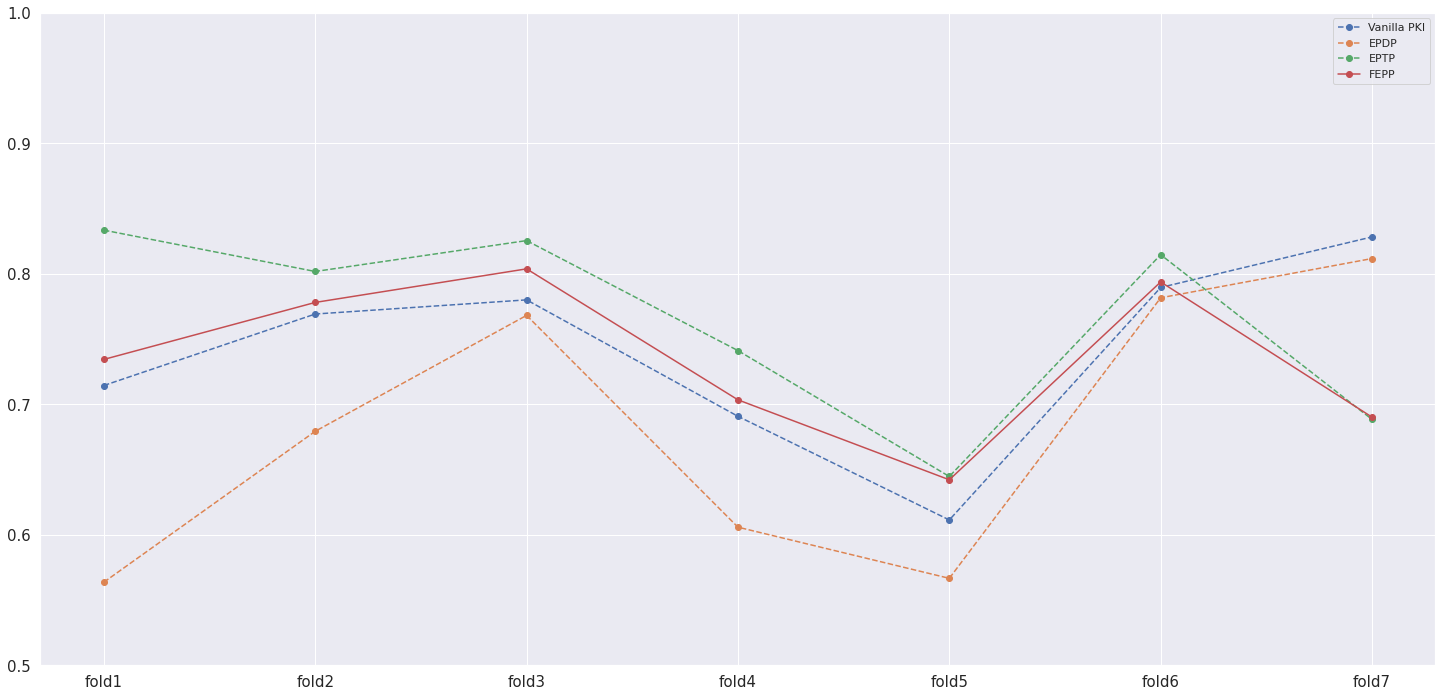

In [50]:
plot(recalls_by_fold)

## Get AVERAGED F1 scores for all four model outputs using AVERAGED PRECISION and RECALL

In [113]:
# Calculate f1 score manually using the averaged calculated precision and recall
def getF1ForAll(precision_scores, recall_scores):
    f1_scores = {}
    f1_scores_by_fold = {}
    for model in precision_scores:
        precisions_per_fold_dict = precision_scores[model]
        recalls_per_fold_dict = recall_scores[model]
        f1s_per_fold_dict= {}
        # get per fold f1 scores
        for fold_num in recalls_per_fold_dict:
            precisions = precisions_per_fold_dict[fold_num]
            recalls = recalls_per_fold_dict[fold_num]
            f1s = [0.0]*5
            # get f1 for five phases for current fold
            for i in range(5):
                f1s[i] = (2*precisions[i]*recalls[i])/(precisions[i]+recalls[i])
            f1s_per_fold_dict[fold_num] = f1s
        # add per fold f1 to the model
        f1_scores[model] = f1s_per_fold_dict
        #ave by phase (len 5)
        ave_scores = getAveScoreAcrossAllVid(f1s_per_fold_dict)
         # get average by fold (vector length: 7)
        ave_scores_by_fold = getAveScoreByFold(f1s_per_fold_dict)
        f1_scores_by_fold[model] = ave_scores_by_fold



        print("Model {}".format(model))
#         print("Per fold f1 socres:")
#         printPerFoldAveScores(f1s_per_fold_dict)
#         print("Average f1 scores for individual phase:\n{}".format(ave_scores))
#         print("Average f1 scores BY FOLD:\n{}".format(ave_scores_by_fold))
        # get mean and std for the score
        mu, sig = norm.fit(ave_scores_by_fold)
        print("Model {} has average score of {} +/- {}".format(model, mu*100, sig*100))
        print()

    return f1_scores_by_fold


In [52]:
f1_scores_by_fold = getF1ForAll(precision_scores, recall_scores)

Model vanilla
Average f1 scores for individual phase:
[0.61536349 0.83470268 0.8867077  0.53281354 0.65973766]
Average f1 scores BY FOLD:
[0.74422977 0.74613796 0.73180659 0.68271142 0.55355723 0.79677484
 0.6858373 ]
Model vanilla has average score of 70.58650145787763 +/- 7.187904947516854

Model epdp
Average f1 scores for individual phase:
[0.66107389 0.87691578 0.90346678 0.32293575 0.65050095]
Average f1 scores BY FOLD:
[0.60172643 0.7004609  0.75260129 0.61524878 0.55168395 0.79439096
 0.76473809]
Model epdp has average score of 68.29786298043807 +/- 8.674906895149277

Model eptp
Average f1 scores for individual phase:
[0.65097201 0.85921123 0.90960864 0.38945543 0.85093837]
Average f1 scores BY FOLD:
[0.82898028 0.77115977 0.78582445 0.71768714 0.64388596 0.78322546
 0.59349691]
Model eptp has average score of 73.2037137250495 +/- 7.89319947330473

Model fepp
Average f1 scores for individual phase:
[0.64469288 0.85946872 0.91928669 0.3475114  0.84915957]
Average f1 scores BY FOL

<Figure size 1080x576 with 0 Axes>

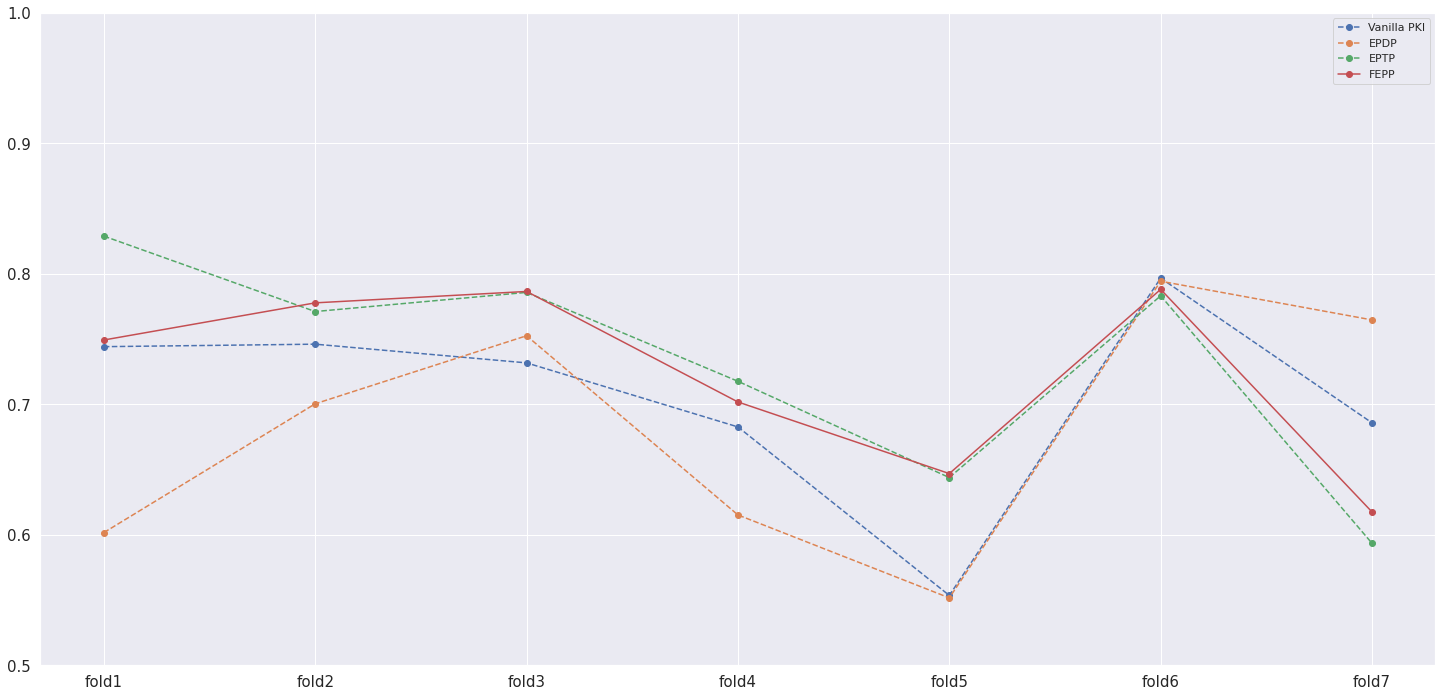

In [53]:
plot(f1_scores_by_fold)

## Plots for averaged model f1 scores per fold

In [54]:
print(f1_scores)

{'cf7cf863-929a-4b89-962b-7913869167e4': {1: 0.662251655629139, 2: 0.8113522537562603, 3: 0.9105490438001235, 4: 0.7368421052631579, 5: 0.9721518987341772}, 'a90983a1-2329-4019-96e8-949493c3fc24': {1: 0.8200000000000001, 2: 0.9348171701112877, 3: 0.9641025641025641, 4: 0.0, 5: 1.0}, '315ac662-9e95-4dec-80f0-48e244f9f8e1': {1: 0.8135593220338982, 2: 0.7755102040816325, 3: 0.9358541525995949, 4: 0.6415094339622641, 5: 0.972972972972973}, 'b71b28f1-7f63-4593-bdb2-9e60dd1ac71e': {1: 0.9791666666666666, 2: 0.9754672897196262, 3: 0.8703517587939699, 4: 0.4666666666666667, 5: 0.7491408934707903}, '96c75293-2026-48af-ad99-37281cb9bb3e': {1: 0.38834951456310685, 2: 0.773936170212766, 3: 0.9158760278304872, 4: 0.320754716981132, 5: 0.9669902912621359}, '436c714b-b588-4894-b68c-1e0f773e5df1': {1: 0.7611336032388665, 2: 0.9026315789473683, 3: 0.9297777777777778, 4: 0.5384615384615384, 5: 0.903448275862069}, '5238ac7b-ad85-488f-b013-9ee4e2064e60': {1: 0.4251968503937008, 2: 0.8809160305343512, 3: 0

## plot model smoothing for a particular fold

### fold 3 and fold 6


In [55]:
names = {"vanilla":"Vanilla PKI",
             "eptp":"EPTP",
             "epdp":"EPDP",
             "fepp":"FEPP",
            }

color = {
    "vanilla":"tab:olive",
     "eptp":"tab:green",
     "epdp":"tab:cyan",
     "fepp":"tab:red",
    
}

In [56]:
def plotCnnPred(cnn_output, true_labels, fold_num):
    figure(figsize=(22, 8))
    x = list(range(len(true_labels)))
    plt.plot(x, true_labels, label="True labels", color='b')
    plt.plot(x, cnn_output, label="CNN predictions", color='tab:orange')
    plt.legend()
    plt.savefig("fold_{}_demo_vid_cnn".format(fold_num), bbox_inches='tight')
    plt.show()

In [163]:
def plotOutput(model, model_output, true_labels, fold_num):
    figure(figsize=(22, 8))
    x = list(range(len(true_labels)))
    plt.yticks(list(range(1,6)), labels=list(range(1,6)))  # Set label locations.
    plt.plot(x, true_labels, label="True labels")
    plt.plot(x, model_output, label="{} outputs".format(names[model]), color=color[model])
    plt.legend()
    plt.savefig("fold_{}_demo_vid_{}".format(fold_num, model), bbox_inches='tight')
    plt.show()

Fold 3 Video 315ac662-9e95-4dec-80f0-48e244f9f8e1


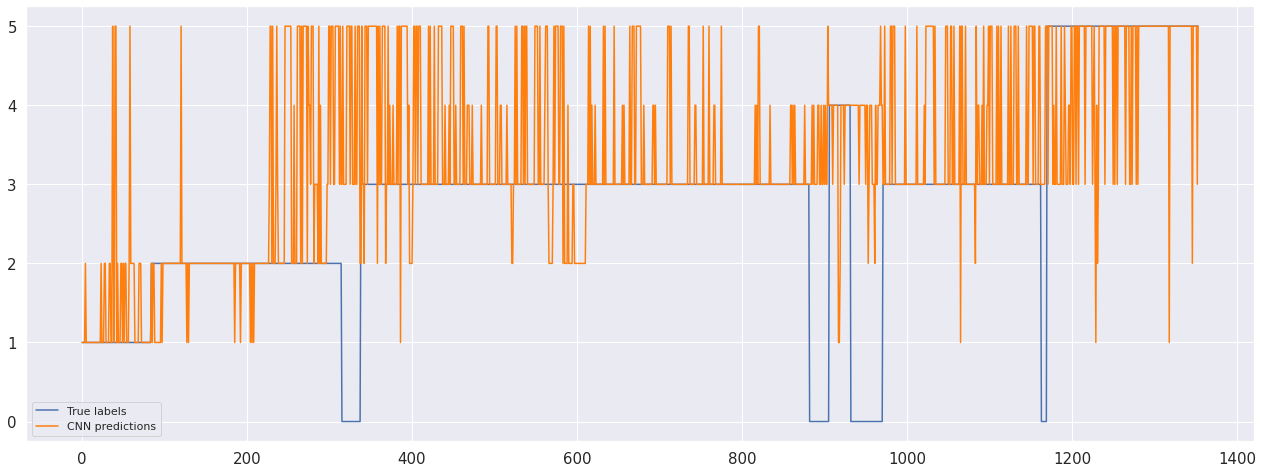

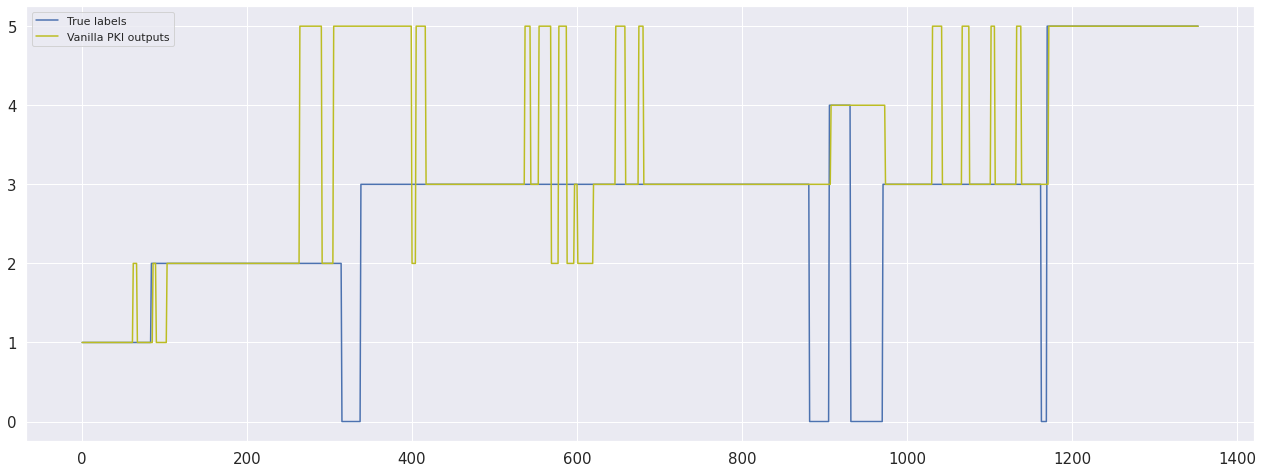

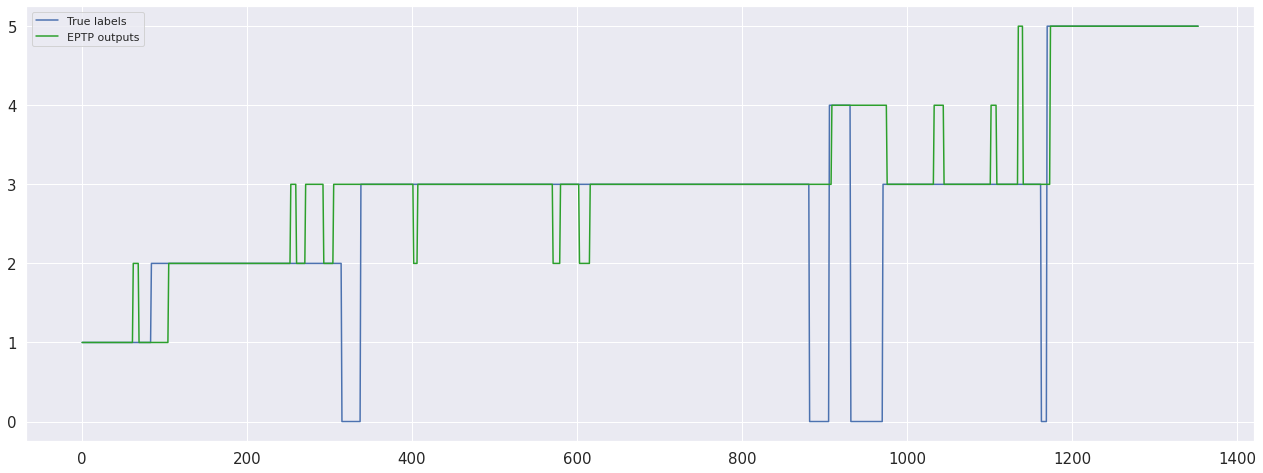

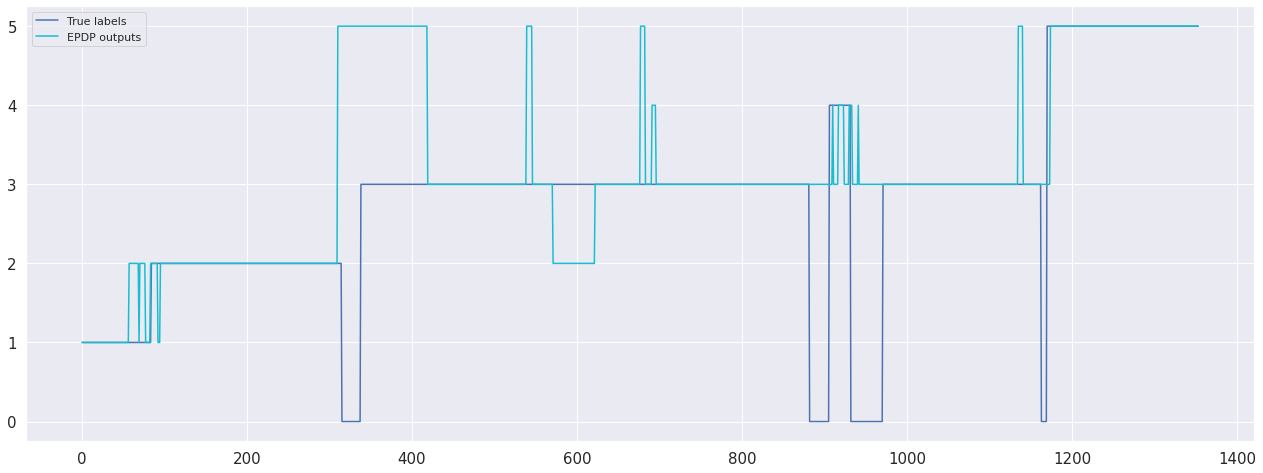

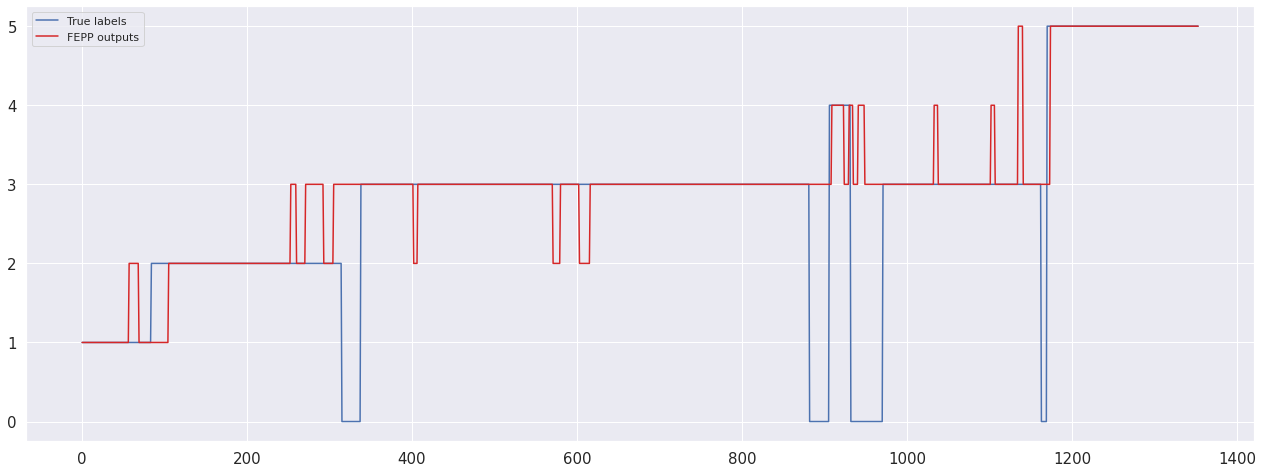

Fold 3 Video a90983a1-2329-4019-96e8-949493c3fc24


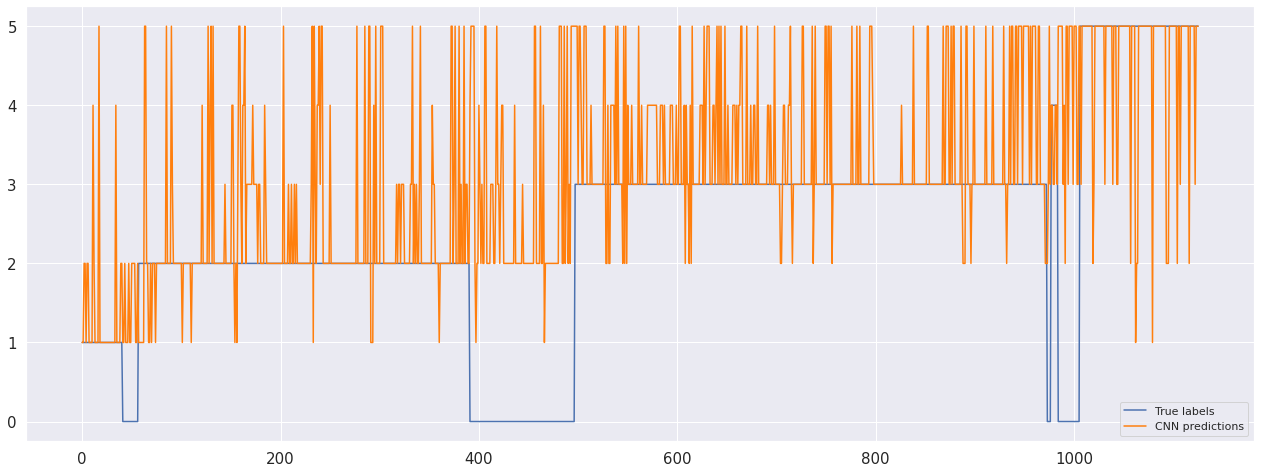

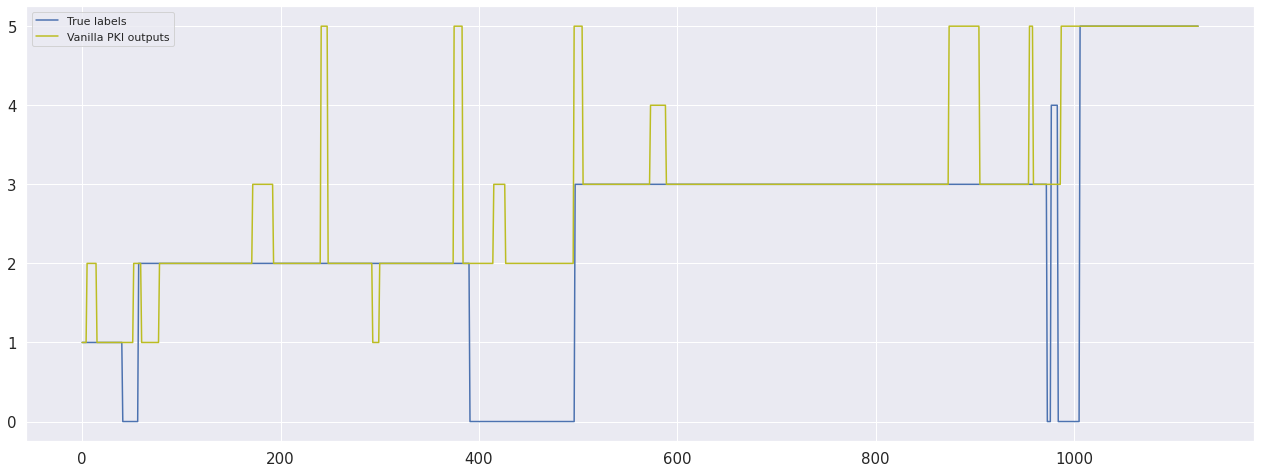

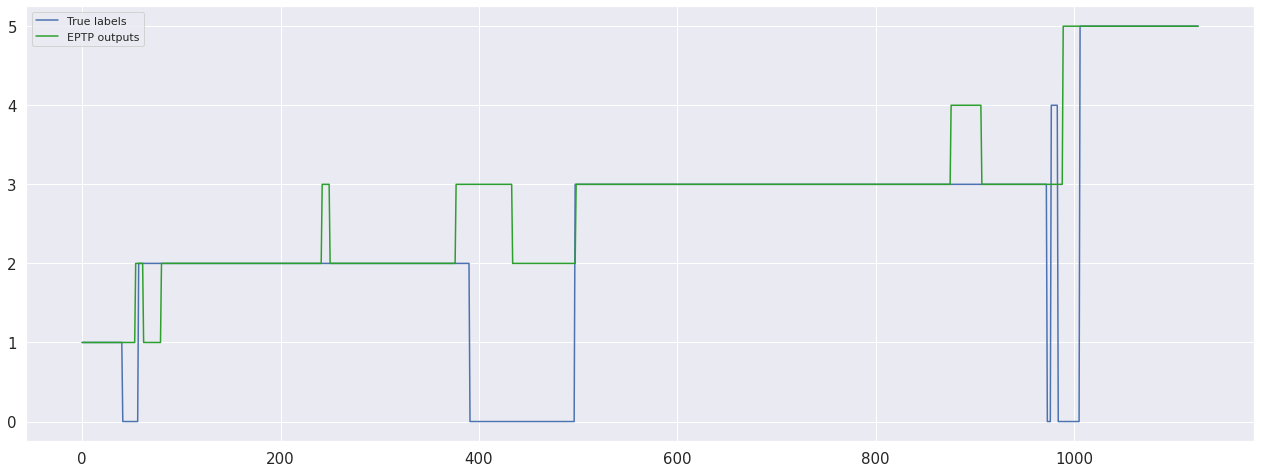

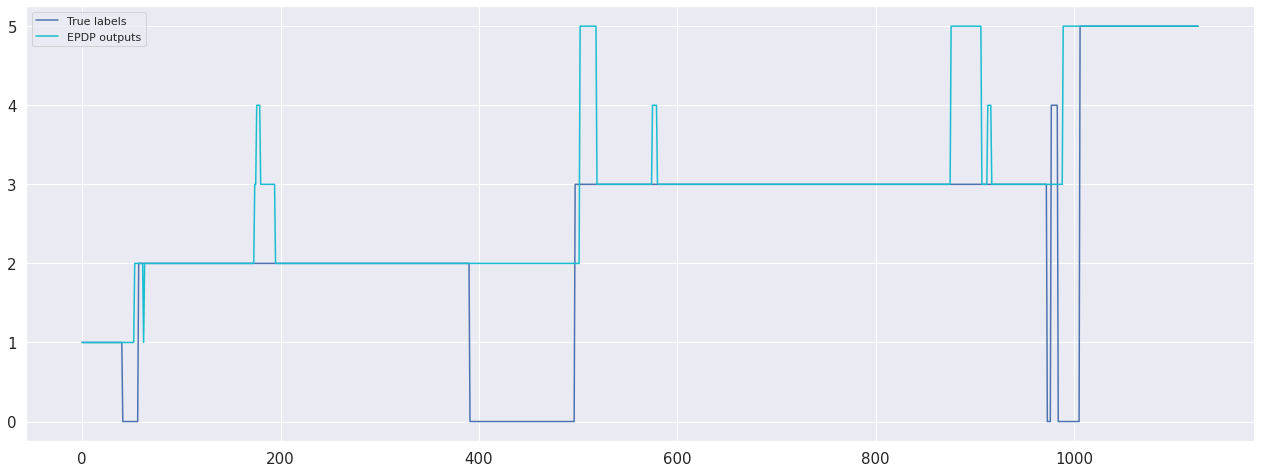

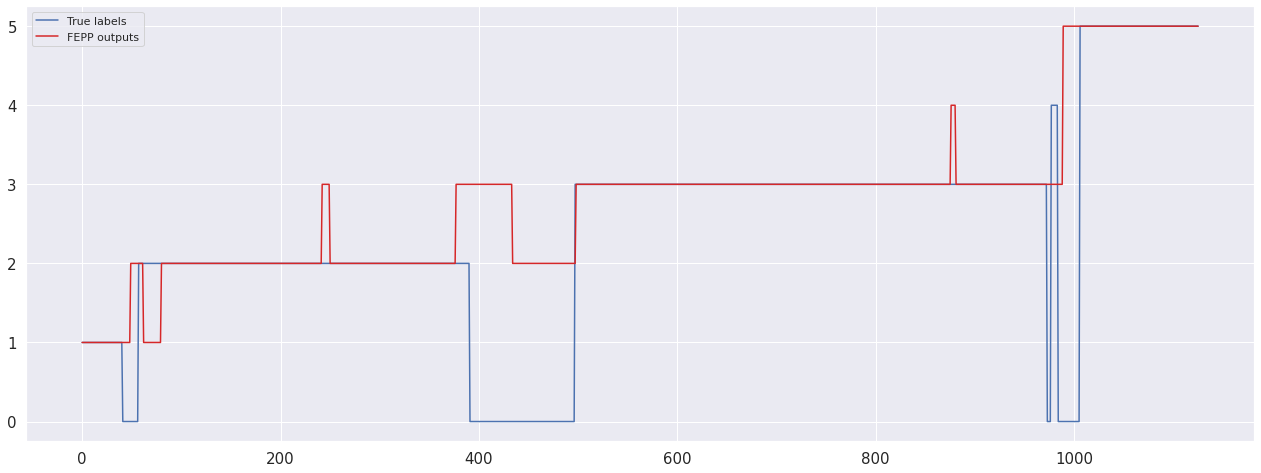

In [58]:
# fold 3:
video_arr = test_folds[3]
for video in video_arr:
    print("Fold 3 Video {}".format(video))
    y_true = true_label_dict[video]
    cnn_pred = pred_label_dict[video]
    plotCnnPred(cnn_pred, y_true, 3)
    for model in names:
        y_model = pki_outputs[model][video]
        plotOutput(model, y_model, y_true, 3)

Fold 6 Video 5238ac7b-ad85-488f-b013-9ee4e2064e60


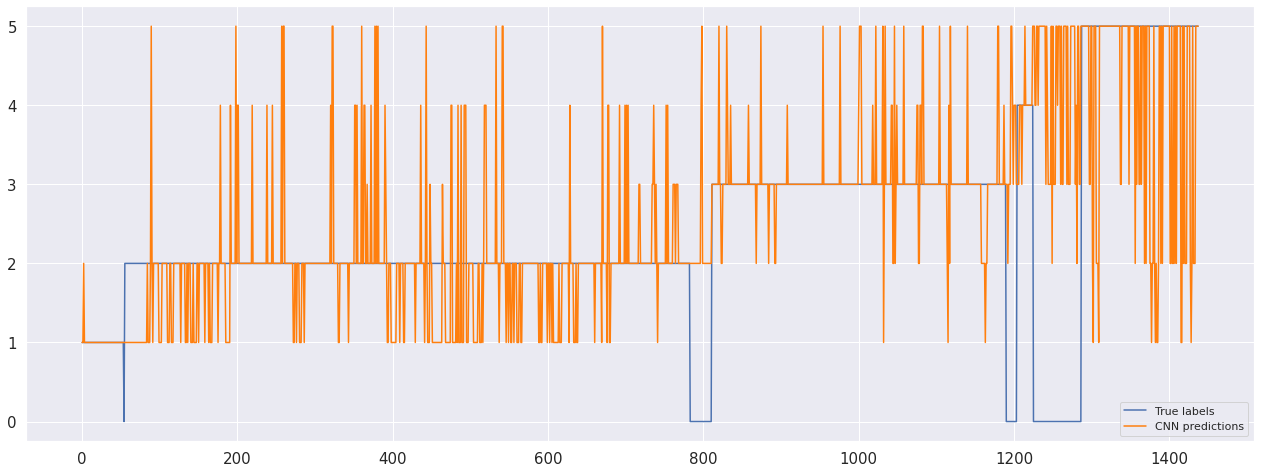

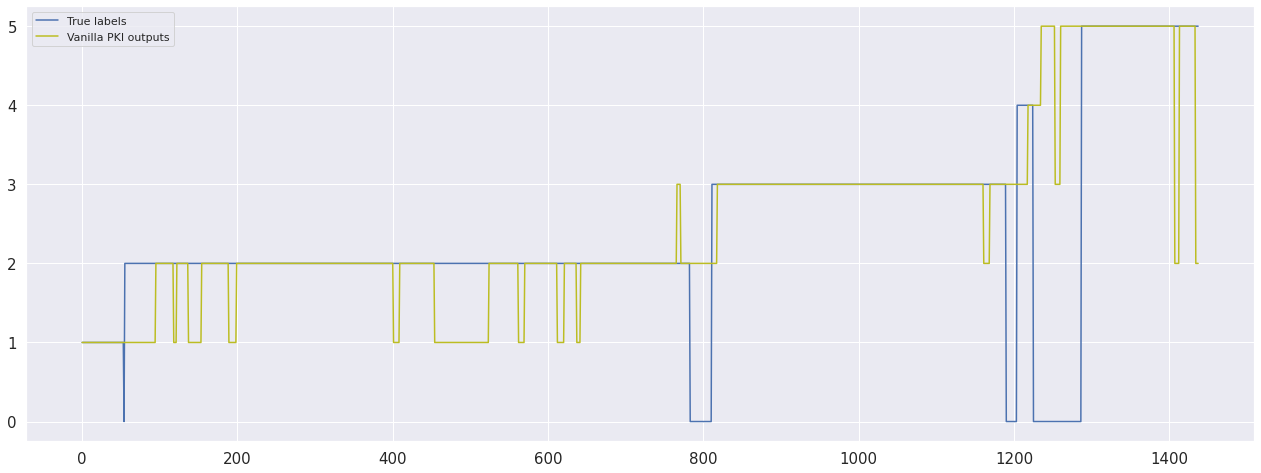

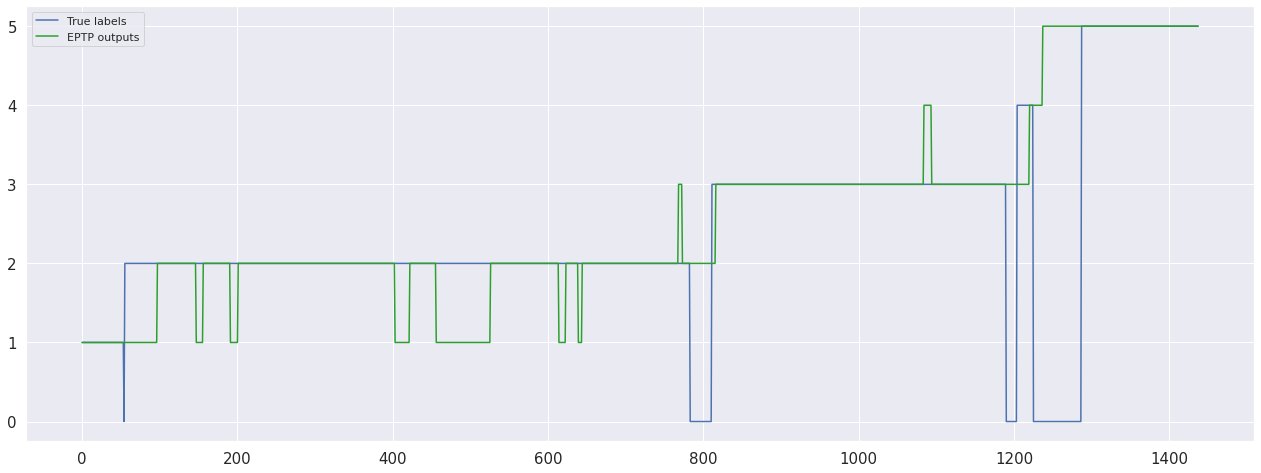

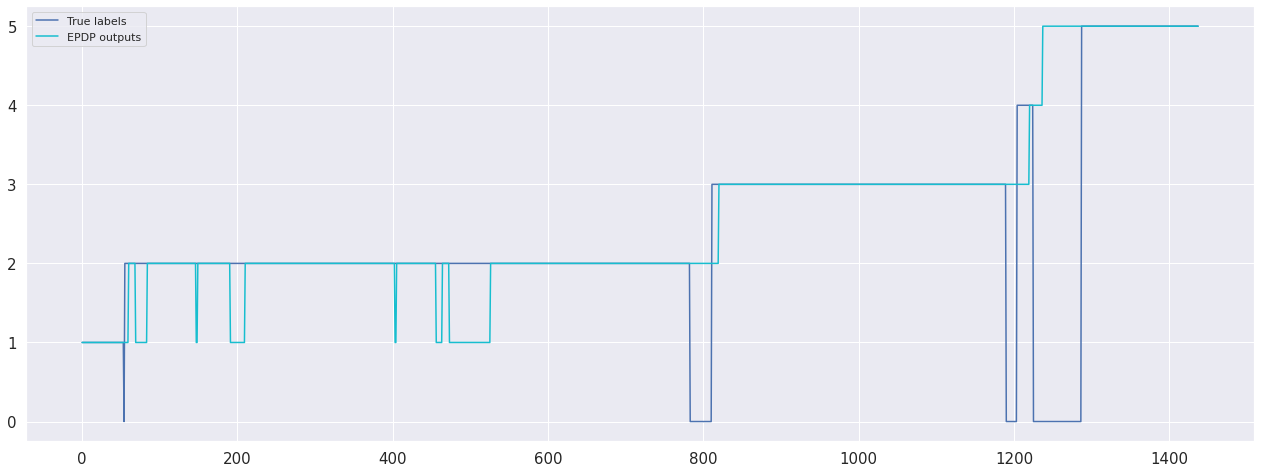

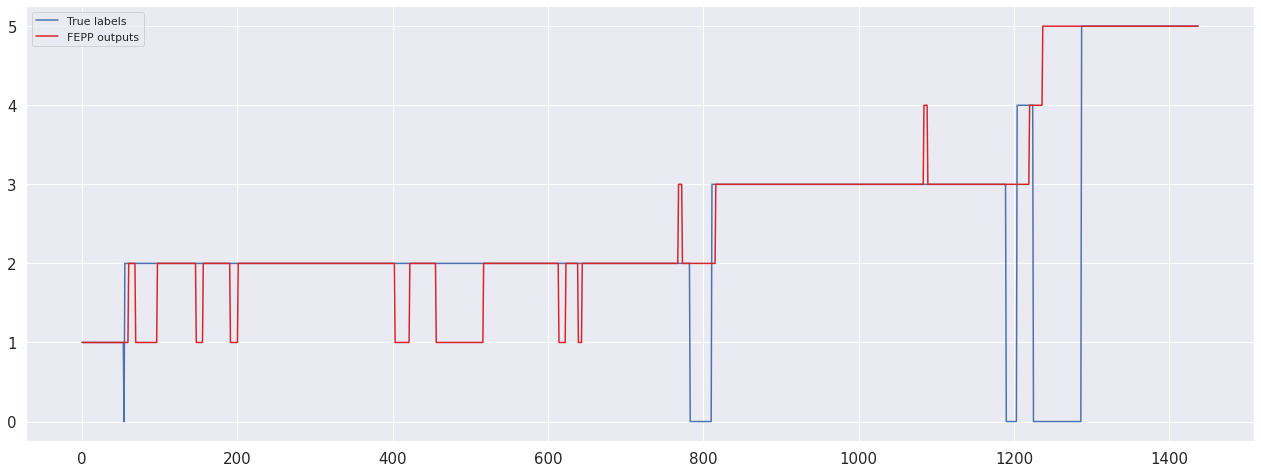

Fold 6 Video 436c714b-b588-4894-b68c-1e0f773e5df1


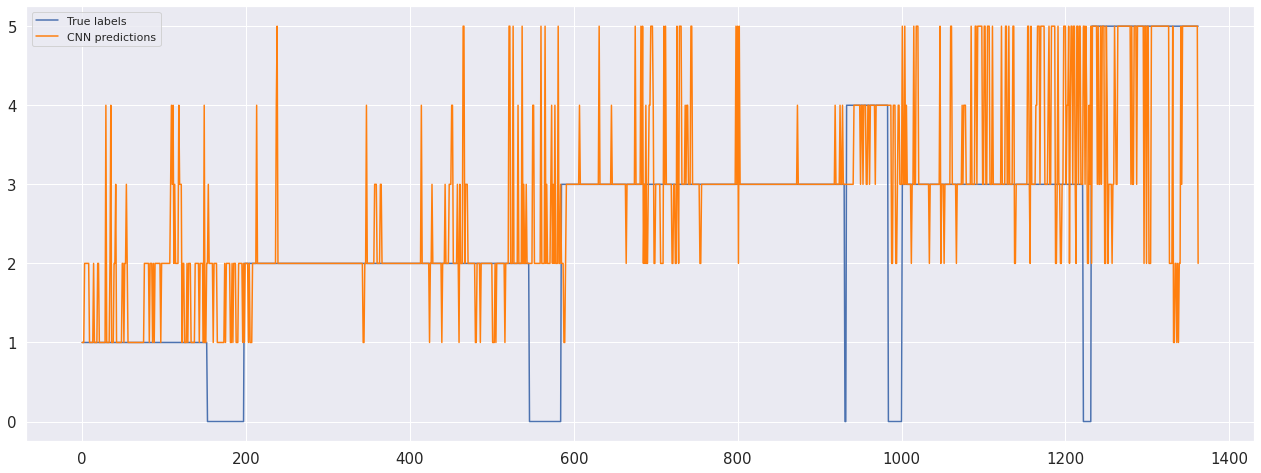

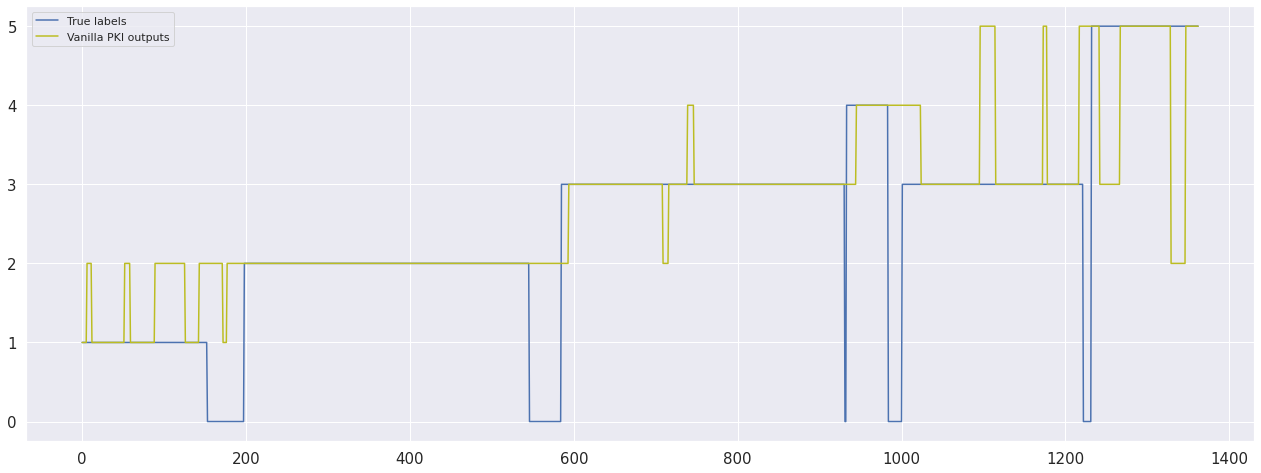

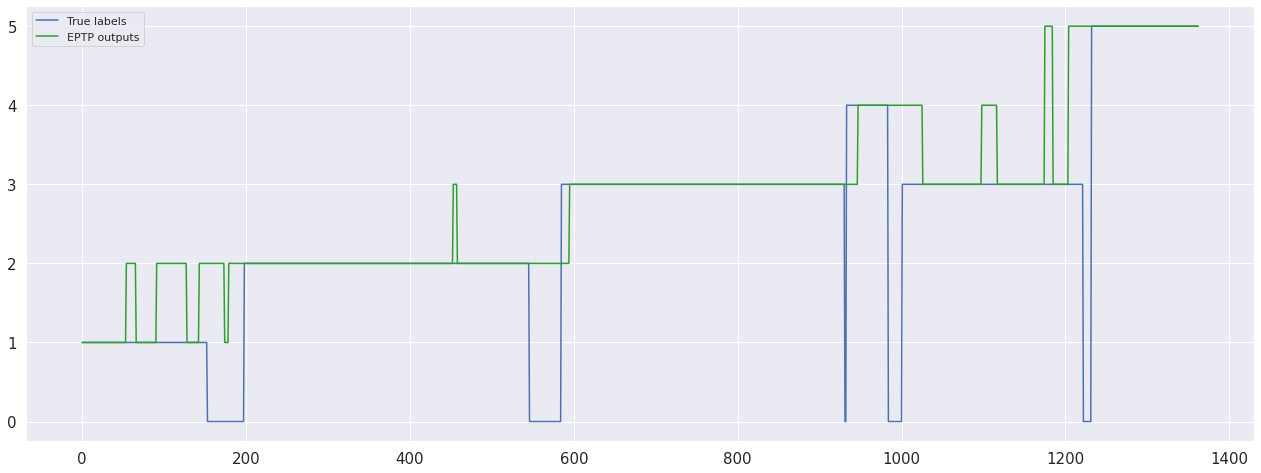

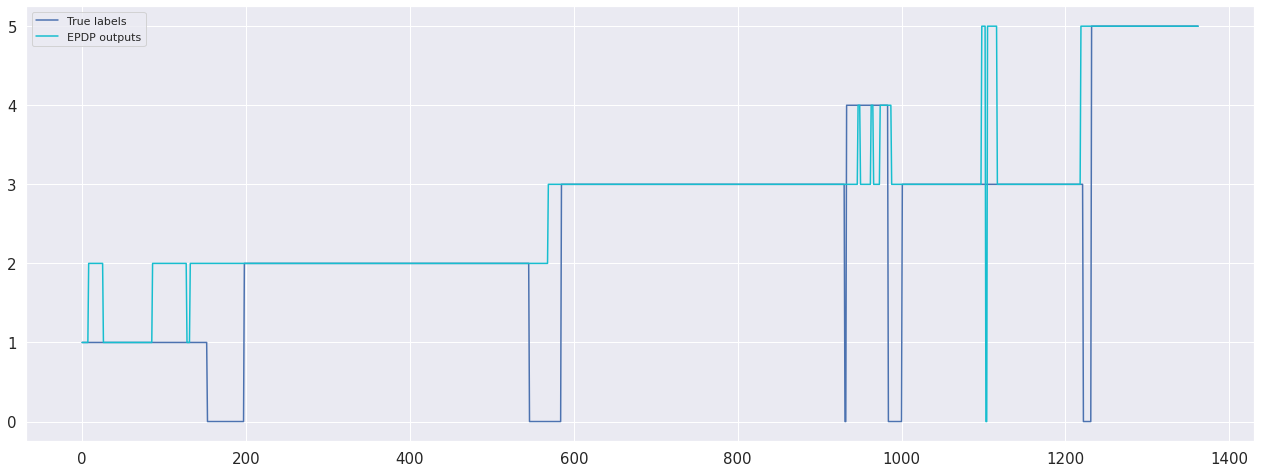

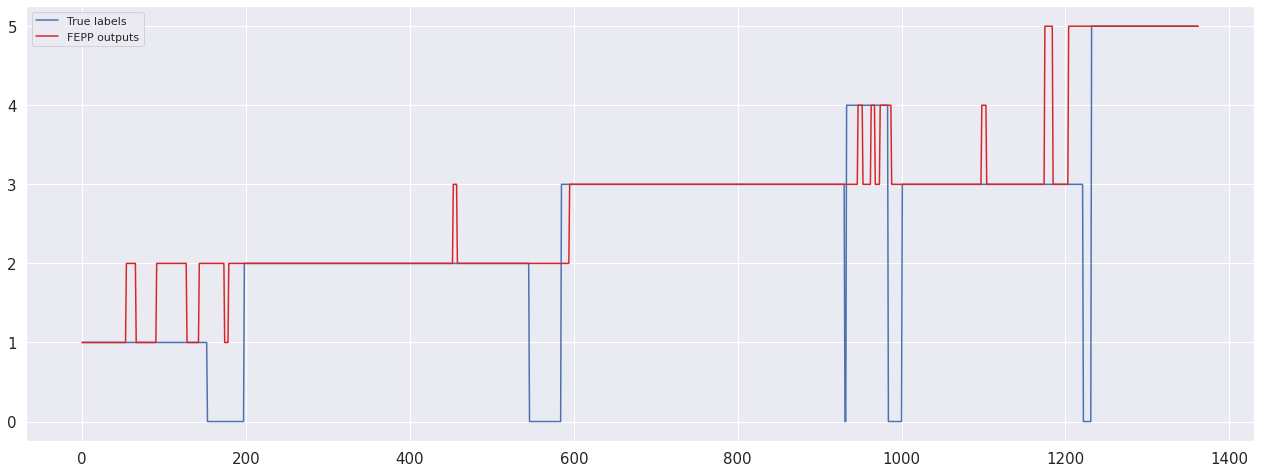

In [59]:
# fold 6:
video_arr = test_folds[6]
for video in video_arr:
    print("Fold 6 Video {}".format(video))
    y_true = true_label_dict[video]
    cnn_pred = pred_label_dict[video]

    plotCnnPred(cnn_pred, y_true, 6)
    for model in names:
        y_model = pki_outputs[model][video]
        plotOutput(model, y_model, y_true, 6)

## Ward metric analysis

In [60]:
import wardmetrics
from wardmetrics.core_methods import eval_events
from wardmetrics.utils import *
from wardmetrics.visualisations import *

In [61]:
data_dict
for vid in data_dict:
    print("{}:".format(vid))
    print("label list:{}\nlabel freq:{}".format(data_dict[vid]["label list"], data_dict[vid]["label freq"]))

cf7cf863-929a-4b89-962b-7913869167e4:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[169, 8, 593, 12, 455, 1, 24, 6, 344, 9, 192]
a90983a1-2329-4019-96e8-949493c3fc24:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 5]
label freq:[41, 16, 334, 106, 476, 4, 7, 22, 120]
315ac662-9e95-4dec-80f0-48e244f9f8e1:
label list:[1, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[84, 231, 23, 544, 24, 26, 39, 192, 7, 184]
b71b28f1-7f63-4593-bdb2-9e60dd1ac71e:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[47, 3, 846, 1, 394, 3, 23, 10, 143, 2, 109]
96c75293-2026-48af-ad99-37281cb9bb3e:
label list:[2, 1, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[146, 101, 254, 17, 550, 1, 73, 14, 190, 15, 266]
436c714b-b588-4894-b68c-1e0f773e5df1:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[153, 45, 348, 39, 346, 2, 51, 17, 221, 10, 131]
5238ac7b-ad85-488f-b013-9ee4e2064e60:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 5]
label freq:[54, 1, 728, 28, 379, 14, 21, 62, 151]
e8d7e0c4-b293-43ce-832f-c37fb8fd3b23:
label l

In [62]:
# get the list of tuples of starting and ending for groundtruth
start_end_dict = {}
for video in data_dict:
#     print(video)
    labels = data_dict[video]["label list"]
    frames = data_dict[video]["label freq"]
    start_end_list = []
    cur_i = 0
    for i, phase in enumerate(labels):
        start = cur_i
        end = cur_i + frames[i]
        start_end_list.append((start, end))
        cur_i = end
    
    start_end_dict[video] = start_end_list
    
# print out
for video in start_end_dict:
    print("{}:".format(video))
    print("ground truth start and end list:{}".format(start_end_dict[video]))
    print()

cf7cf863-929a-4b89-962b-7913869167e4:
ground truth start and end list:[(0, 169), (169, 177), (177, 770), (770, 782), (782, 1237), (1237, 1238), (1238, 1262), (1262, 1268), (1268, 1612), (1612, 1621), (1621, 1813)]

a90983a1-2329-4019-96e8-949493c3fc24:
ground truth start and end list:[(0, 41), (41, 57), (57, 391), (391, 497), (497, 973), (973, 977), (977, 984), (984, 1006), (1006, 1126)]

315ac662-9e95-4dec-80f0-48e244f9f8e1:
ground truth start and end list:[(0, 84), (84, 315), (315, 338), (338, 882), (882, 906), (906, 932), (932, 971), (971, 1163), (1163, 1170), (1170, 1354)]

b71b28f1-7f63-4593-bdb2-9e60dd1ac71e:
ground truth start and end list:[(0, 47), (47, 50), (50, 896), (896, 897), (897, 1291), (1291, 1294), (1294, 1317), (1317, 1327), (1327, 1470), (1470, 1472), (1472, 1581)]

96c75293-2026-48af-ad99-37281cb9bb3e:
ground truth start and end list:[(0, 146), (146, 247), (247, 501), (501, 518), (518, 1068), (1068, 1069), (1069, 1142), (1142, 1156), (1156, 1346), (1346, 1361), (136

In [63]:
# get prediction phases starting and ending
def getStartEndPred(pred_sequence):
    detection_start_end = []
    phase_labels = []
    start = 0
    cur_i = 0
    cur_pred = pred_sequence[0]
    for y in pred_sequence:
        if y != cur_pred:
            detection_start_end.append((start, cur_i))
            phase_labels.append(cur_pred)
            start = cur_i
            cur_pred = y 
        cur_i += 1
    # add the last one
    detection_start_end.append((start, cur_i))
    phase_labels.append(cur_pred)
    return (detection_start_end, phase_labels)

Using version 0.9.5
Standard event results:
	precision:	0.8888888888888888	Weighted by length:	0.9186991869918699
	recall:		0.875	Weighted by length:	0.898989898989899
Detailed event results:
	Actual events:
		deletions:			1	12.50% of actual events
		merged:				3	37.50% of actual events
		fragmented:			1	12.50% of actual events
		frag. and merged:	1	12.50% of actual events
		correct:			2	25.00% of actual events
	Detected events:
		insertions:			1	11.11% of detected events
		merging:			1	11.11% of detected events
		fragmenting:		4	44.44% of detected events
		frag. and merging:	1	11.11% of detected events
		correct:			2	22.22% of detected events
[0.8888888888888888, 0.875, 0.9186991869918699, 0.898989898989899]
[0.8888888888888888, 0.875, 0.9186991869918699, 0.898989898989899]
(0.8888888888888888;0.875;0.9186991869918699;0.898989898989899)

[2, 1, 3, 1, 1, 4, 1, 1, 1, 8, 9]
[2, 1, 3, 1, 1, 4, 1, 1, 1, 8, 9]
(2;1;3;1;1;4;1;1;1;8;9)



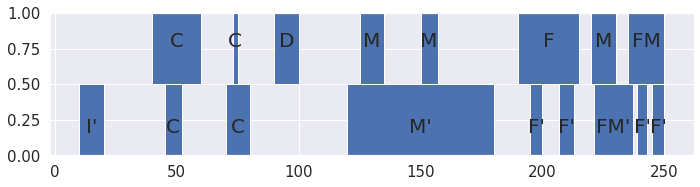

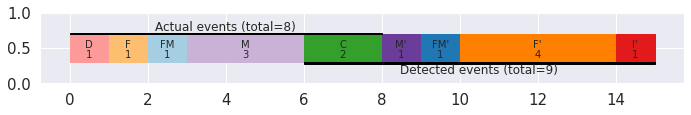

['C', 'C', 'D', 'M', 'M', 'F', 'M', 'FM']
["I'", 'C', 'C', "M'", "F'", "F'", "FM'", "F'", "F'"]
{'total_gt': 8, 'total_det': 9, 'D': 1, 'F': 1, 'FM': 1, 'M': 3, 'C': 2, "M'": 1, "FM'": 1, "F'": 4, "I'": 1}


In [64]:
# measure ward metrics for each video
import wardmetrics
from wardmetrics.core_methods import eval_events
from wardmetrics.utils import *
from wardmetrics.visualisations import *

ground_truth_test = [
    (40, 60),
    (73, 75),
    (90, 100),
    (125, 135),
    (150, 157),
    (190, 215),
    (220, 230),
    (235, 250),
]

detection_test = [
    (10, 20),
    (45, 52),
    (70, 80),
    (120, 180),
    (195, 200),
    (207, 213),
    (221, 237),
    (239, 243),
    (245, 250),
]

print("Using version",  wardmetrics.__version__)

# Run event-based evaluation:
gt_event_scores, det_event_scores, detailed_scores, standard_scores = eval_events(ground_truth_test, detection_test)

# Print results:
print_standard_event_metrics(standard_scores)
print_detailed_event_metrics(detailed_scores)

# Access results in other formats:
print(standard_event_metrics_to_list(standard_scores)) # standard scores as basic python list, order: p, r, p_w, r_w
print(standard_event_metrics_to_string(standard_scores)) # standard scores as string line, order: p, r, p_w, r_w)
print(standard_event_metrics_to_string(standard_scores, separator=";", prefix="(", suffix=")\n")) # standard scores as string line, order: p, r, p_w, r_w

print(detailed_event_metrics_to_list(detailed_scores)) # detailed scores as basic python list
print(detailed_event_metrics_to_string(detailed_scores)) # detailed scores as string line
print(detailed_event_metrics_to_string(detailed_scores, separator=";", prefix="(", suffix=")\n")) # standard scores as string line


# Show results:
plot_events_with_event_scores(gt_event_scores, det_event_scores, ground_truth_test, detection_test, show=False)
plot_event_analysis_diagram(detailed_scores)

print(gt_event_scores)
print(det_event_scores)
print(detailed_scores)


In [65]:
target_video = "315ac662-9e95-4dec-80f0-48e244f9f8e1"

In [66]:
# fold 5 has the best performance
# get the first video from fold 5 and plot event diagram
ground_truth_label = start_end_dict[target_video]
data_labels = data_dict[target_video]
print(data_labels)
print(ground_truth_label)


{'label list': [1, 2, 0, 3, 0, 4, 0, 3, 0, 5], 'label freq': [84, 231, 23, 544, 24, 26, 39, 192, 7, 184]}
[(0, 84), (84, 315), (315, 338), (338, 882), (882, 906), (906, 932), (932, 971), (971, 1163), (1163, 1170), (1170, 1354)]


In [67]:
det_events = {}
for model in pki_outputs:
    f5_det, phases = getStartEndPred(pki_outputs[model][target_video])
    det_events[model] = (f5_det, phases)
    print("Fold 5 target video detection events start and end for model {}:\n{}\n{}\n".format(model, f5_det, phases))

Fold 5 target video detection events start and end for model vanilla:
[(0, 62), (62, 67), (67, 86), (86, 90), (90, 103), (103, 264), (264, 291), (291, 305), (305, 400), (400, 405), (405, 417), (417, 537), (537, 544), (544, 554), (554, 569), (569, 578), (578, 588), (588, 597), (597, 601), (601, 620), (620, 647), (647, 659), (659, 675), (675, 681), (681, 908), (908, 974), (974, 1031), (1031, 1043), (1043, 1067), (1067, 1076), (1076, 1102), (1102, 1107), (1107, 1133), (1133, 1139), (1139, 1172), (1172, 1354)]
[1, 2, 1, 2, 1, 2, 5, 2, 5, 2, 5, 3, 5, 3, 5, 2, 5, 2, 3, 2, 3, 5, 3, 5, 3, 4, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5]

Fold 5 target video detection events start and end for model epdp:
[(0, 57), (57, 69), (69, 70), (70, 77), (77, 83), (83, 92), (92, 95), (95, 310), (310, 419), (419, 539), (539, 546), (546, 571), (571, 622), (622, 677), (677, 683), (683, 691), (691, 696), (696, 910), (910, 911), (911, 917), (917, 924), (924, 930), (930, 934), (934, 941), (941, 942), (942, 1135), (1135, 1141),

In [68]:
def getPhaseGTEvents(gt_start_end, phases, phase):
    start_end_by_phase = []
    for i in range(len(phases)):
        if phases[i] != 0 and phases[i] == phase:
            start_end_by_phase.append(gt_start_end[i])
#     # loop through the list to add the remaining intervals
#     cur = 0
#     original = start_end_by_phase.copy()
#     for interval in original:
# #             print("Interval:{}".format(interval))
#         if interval[0] > cur:
#             start_end_by_phase.append((cur, interval[0]))
#         cur = interval[1]
# #             print(cur)
#     start_end_by_phase.append((cur, tot))
#     start_end_by_phase.sort()
    return start_end_by_phase

In [69]:
def getPhaseDetEvents(det_events, phase):
    det_events_by_phase = {}
    for model in det_events:
        start_end_by_phase = []
        f5_det, phases = det_events[model]
        for i in range(len(phases)):
            if phases[i] == 0:
                continue
            if phases[i] == phase:
                start_end_by_phase.append(f5_det[i])
# #         # loop through the list to add the remaining intervals
#         cur = 0
#         original = start_end_by_phase.copy()
#         for interval in original:
# #             print("Interval:{}".format(interval))
#             if interval[0] > cur:
#                 start_end_by_phase.append((cur, interval[0]))
#             cur = interval[1]
# #             print(cur)
#         start_end_by_phase.append((cur, tot))
#         start_end_by_phase.sort()
        det_events_by_phase[model] = start_end_by_phase
#         print()
    return det_events_by_phase

In [70]:
def getWardRes(gt, dt):
    # Run event-based evaluation:
    gt_event_scores, det_event_scores, detailed_scores, standard_scores = eval_events(gt, dt)

    # Print results:
#     print_standard_event_metrics(standard_scores)
#     print_detailed_event_metrics(detailed_scores)

    # Access results in other formats:
#     print(standard_event_metrics_to_list(standard_scores)) # standard scores as basic python list, order: p, r, p_w, r_w
#     print(standard_event_metrics_to_string(standard_scores)) # standard scores as string line, order: p, r, p_w, r_w)
#     print(standard_event_metrics_to_string(standard_scores, separator=";", prefix="(", suffix=")\n")) # standard scores as string line, order: p, r, p_w, r_w

#     print(detailed_event_metrics_to_list(detailed_scores)) # detailed scores as basic python list
#     print(detailed_event_metrics_to_string(detailed_scores)) # detailed scores as string line
#     print(detailed_event_metrics_to_string(detailed_scores, separator=";", prefix="(", suffix=")\n")) # standard scores as string line


    # Show results:
#     plot_events_with_event_scores(gt_event_scores, det_event_scores, gt, dt, show=False)
#     plot_event_analysis_diagram(detailed_scores)

#     print(gt_event_scores)
#     print(det_event_scores)
#     print(detailed_scores)
    
    return(gt_event_scores, det_event_scores, detailed_scores)

In [71]:
per_phase_ward_metric = {}

In [72]:
# get ward metric by phase: phase 1
phase_ward = {}
f5ph1_gt = getPhaseGTEvents(ground_truth_label, data_labels["label list"], 1)
f5ph1_dt = getPhaseDetEvents(det_events, 1)
print(f5ph1_gt)
print(f5ph1_dt)

[(0, 84)]
{'vanilla': [(0, 62), (67, 86), (90, 103)], 'epdp': [(0, 57), (69, 70), (77, 83), (92, 95)], 'eptp': [(0, 62), (69, 105)], 'fepp': [(0, 57), (69, 105)]}


{'vanilla': [(0, 62), (67, 86), (90, 103)],
 'epdp': [(0, 57), (69, 70), (77, 83), (92, 95)],
 'eptp': [(0, 62), (69, 105)],
 'fepp': [(0, 57), (69, 105)]}

In [73]:
for model in f5ph1_dt:
    print("Model:{}".format(model))
    phase_ward[model] = getWardRes(f5ph1_gt, f5ph1_dt[model])
per_phase_ward_metric[1] = phase_ward

Model:vanilla
Model:epdp
Model:eptp
Model:fepp


In [74]:
# get ward metric by phase: phase 2
f5ph_gt = getPhaseGTEvents(ground_truth_label, data_labels["label list"], 2)
f5ph_dt = getPhaseDetEvents(det_events, 2)
phase_ward = {}
for model in f5ph_dt:
    print("Model:{}".format(model))
    phase_ward[model] = getWardRes(f5ph_gt, f5ph_dt[model])
per_phase_ward_metric[2] = phase_ward

Model:vanilla
Model:epdp
Model:eptp
Model:fepp


In [75]:
# get ward metric by phase: phase 3
f5ph_gt = getPhaseGTEvents(ground_truth_label, data_labels["label list"], 3)
f5ph_dt = getPhaseDetEvents(det_events, 3)
phase_ward = {}
for model in f5ph_dt:
    print("Model:{}".format(model))
    phase_ward[model] = getWardRes(f5ph_gt, f5ph_dt[model])
per_phase_ward_metric[3] = phase_ward

Model:vanilla
Model:epdp
Model:eptp
Model:fepp


In [76]:
# get ward metric by phase: phase 4
f5ph_gt = getPhaseGTEvents(ground_truth_label, data_labels["label list"], 4)
f5ph_dt = getPhaseDetEvents(det_events, 4)
phase_ward = {}
for model in f5ph_dt:
    print("Model:{}".format(model))
    phase_ward[model] = getWardRes(f5ph_gt, f5ph_dt[model])
per_phase_ward_metric[4] = phase_ward

Model:vanilla
Model:epdp
Model:eptp
Model:fepp


In [77]:
# get ward metric by phase: phase 5
f5ph_gt = getPhaseGTEvents(ground_truth_label, data_labels["label list"], 5)
f5ph_dt = getPhaseDetEvents(det_events, 5)
phase_ward = {}
for model in f5ph_dt:
    print("Model:{}".format(model))
    phase_ward[model] = getWardRes(f5ph_gt, f5ph_dt[model])
per_phase_ward_metric[5] = phase_ward

Model:vanilla
Model:epdp
Model:eptp
Model:fepp


In [78]:
# combine everything manually
per_phase_ward_metric

{1: {'vanilla': (['F'],
   ["F'", "F'", "I'"],
   {'total_gt': 1,
    'total_det': 3,
    'D': 0,
    'F': 1,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 2,
    "I'": 1}),
  'epdp': (['F'],
   ["F'", "F'", "F'", "I'"],
   {'total_gt': 1,
    'total_det': 4,
    'D': 0,
    'F': 1,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 3,
    "I'": 1}),
  'eptp': (['F'],
   ["F'", "F'"],
   {'total_gt': 1,
    'total_det': 2,
    'D': 0,
    'F': 1,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 2,
    "I'": 0}),
  'fepp': (['F'],
   ["F'", "F'"],
   {'total_gt': 1,
    'total_det': 2,
    'D': 0,
    'F': 1,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 2,
    "I'": 0})},
 2: {'vanilla': (['F'],
   ["I'", "F'", "F'", "F'", "I'", "I'", "I'", "I'"],
   {'total_gt': 1,
    'total_det': 8,
    'D': 0,
    'F': 1,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 3

{'total_gt': 6, 'total_det': 36, 'D': 0, 'F': 4, 'FM': 0, 'M': 0, 'C': 2, "M'": 0, "FM'": 0, "F'": 16, "I'": 18}


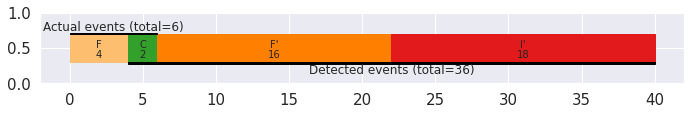

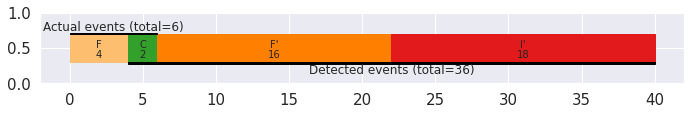

In [79]:
# vanilla
final_detailed_scores = {
    'total_gt': 0,
    'total_det': 0,
    'D': 0,
    'F': 0,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 0,
    "I'": 0}
for phase in per_phase_ward_metric:
    ds_dict = per_phase_ward_metric[phase]["vanilla"][2]
    for eachKey in ds_dict:
        final_detailed_scores[eachKey] += ds_dict[eachKey]
print(final_detailed_scores)
plot_event_analysis_diagram(final_detailed_scores)

{'total_gt': 6, 'total_det': 29, 'D': 0, 'F': 5, 'FM': 0, 'M': 0, 'C': 1, "M'": 0, "FM'": 0, "F'": 15, "I'": 13}


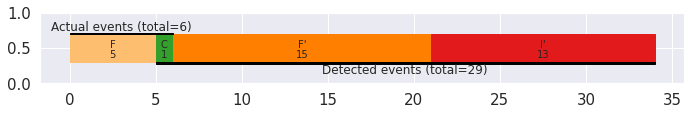

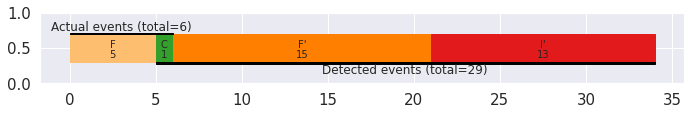

In [80]:
# epdp
final_detailed_scores = {
    'total_gt': 0,
    'total_det': 0,
    'D': 0,
    'F': 0,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 0,
    "I'": 0}
for phase in per_phase_ward_metric:
    ds_dict = per_phase_ward_metric[phase]["epdp"][2]
    for eachKey in ds_dict:
        final_detailed_scores[eachKey] += ds_dict[eachKey]
print(final_detailed_scores)
plot_event_analysis_diagram(final_detailed_scores)

{'total_gt': 6, 'total_det': 24, 'D': 0, 'F': 4, 'FM': 0, 'M': 0, 'C': 2, "M'": 0, "FM'": 0, "F'": 13, "I'": 9}


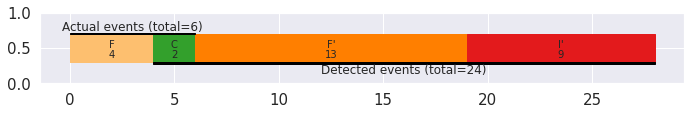

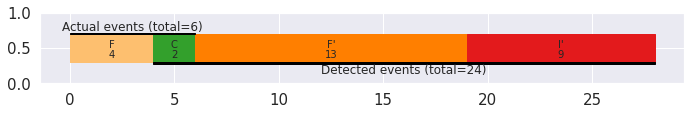

In [81]:
# eptp
final_detailed_scores = {
    'total_gt': 0,
    'total_det': 0,
    'D': 0,
    'F': 0,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 0,
    "I'": 0}
for phase in per_phase_ward_metric:
    ds_dict = per_phase_ward_metric[phase]["eptp"][2]
    for eachKey in ds_dict:
        final_detailed_scores[eachKey] += ds_dict[eachKey]
print(final_detailed_scores)
plot_event_analysis_diagram(final_detailed_scores)

{'total_gt': 6, 'total_det': 28, 'D': 0, 'F': 5, 'FM': 0, 'M': 0, 'C': 1, "M'": 0, "FM'": 0, "F'": 15, "I'": 12}


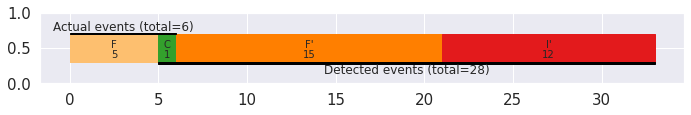

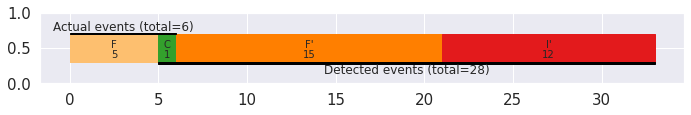

In [82]:
# fepp
final_detailed_scores = {
    'total_gt': 0,
    'total_det': 0,
    'D': 0,
    'F': 0,
    'FM': 0,
    'M': 0,
    'C': 0,
    "M'": 0,
    "FM'": 0,
    "F'": 0,
    "I'": 0}
for phase in per_phase_ward_metric:
    ds_dict = per_phase_ward_metric[phase]["fepp"][2]
    for eachKey in ds_dict:
        final_detailed_scores[eachKey] += ds_dict[eachKey]
print(final_detailed_scores)
plot_event_analysis_diagram(final_detailed_scores)

In [83]:
# get averaged values for fold 3

def getAveEventScores(videoSequence):
    final_scores = {}
    for target_video in videoSequence:
        ground_truth_label = start_end_dict[target_video]
        data_labels = data_dict[target_video]
        det_events = {}
        for model in pki_outputs:
            f5_det, phases = getStartEndPred(pki_outputs[model][target_video])
            det_events[model] = (f5_det, phases)
        #get per phase event
        per_phase_ward_metric = {}
        for phase in range(1,6):
            # get ward metric by phase
            f5ph_gt = getPhaseGTEvents(ground_truth_label, data_labels["label list"], phase)
            f5ph_dt = getPhaseDetEvents(det_events, phase)
            phase_ward = {}
            for model in f5ph_dt:
                print("Model:{}".format(model))
                phase_ward[model] = getWardRes(f5ph_gt, f5ph_dt[model])
            per_phase_ward_metric[phase] = phase_ward

        #plot the event diagram
        for model in pki_outputs:
            final_detailed_scores = {
                'total_gt': 0,
                'total_det': 0,
                'D': 0,
                'F': 0,
                'FM': 0,
                'M': 0,
                'C': 0,
                "M'": 0,
                "FM'": 0,
                "F'": 0,
                "I'": 0}
            for phase in per_phase_ward_metric:
                ds_dict = per_phase_ward_metric[phase][model][2]
                for eachKey in ds_dict:
                    final_detailed_scores[eachKey] += ds_dict[eachKey]

            if model in final_scores:
                for eachKey in final_detailed_scores:
                    final_scores[model][eachKey] = (final_detailed_scores[eachKey] + final_scores[model][eachKey])/2
            else:
                final_scores[model] = final_detailed_scores
    # plot averaged results
    for model in pki_outputs:
        print("Model {}".format(model))
        print(final_scores[model])
        plot_event_analysis_diagram(final_scores[model])

Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model:vanilla
Model:epdp
Model:eptp
Model:fepp
Model vanilla
{'total_gt': 5.5, 'total_det': 30.5, 'D': 0.5, 'F': 3.5, 'FM': 0.0, 'M': 0.0, 'C': 1.5, "M'": 0.0, "FM'": 0.0, "F'": 14.0, "I'": 15.0}


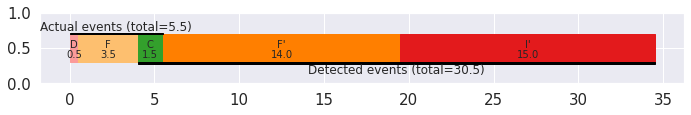

Model epdp
{'total_gt': 5.5, 'total_det': 23.0, 'D': 0.5, 'F': 3.5, 'FM': 0.0, 'M': 0.0, 'C': 1.5, "M'": 0.0, "FM'": 0.0, "F'": 11.0, "I'": 10.5}


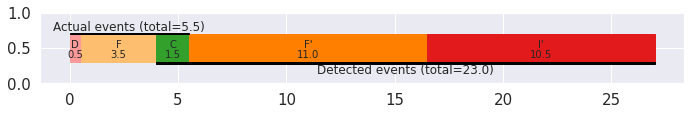

Model eptp
{'total_gt': 5.5, 'total_det': 18.0, 'D': 0.5, 'F': 3.0, 'FM': 0.0, 'M': 0.0, 'C': 2.0, "M'": 0.0, "FM'": 0.0, "F'": 9.0, "I'": 7.0}


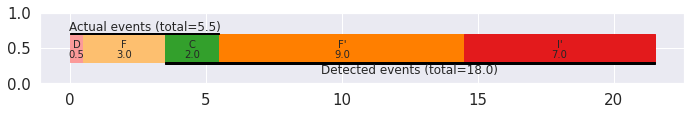

Model fepp
{'total_gt': 5.5, 'total_det': 20.0, 'D': 0.5, 'F': 3.5, 'FM': 0.0, 'M': 0.0, 'C': 1.5, "M'": 0.0, "FM'": 0.0, "F'": 10.0, "I'": 8.5}


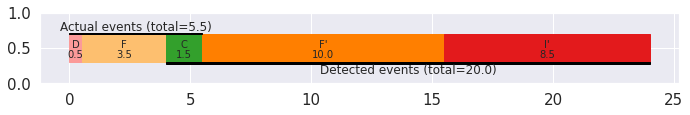

In [84]:
getAveEventScores(test_folds[3])

# Run evaluation on models outputs on improved seq models


# LSTM100

In [85]:
# load vanilla and extended PKI models results
pki_res_path = "./seq_models_outputs/"
os.listdir(pki_res_path)

['jenna_model_on_L100_outputs.pickle',
 'jenna_model_on_T90_outputs.pickle',
 'trans90_noise_pred_dict.pickle',
 'ma_pred_dict.pickle',
 'lstm100_noise_pred_dict.pickle',
 'jenna_model_on_ma_outputs.pickle']

In [86]:
pki_output_L100_dict = pickle.load(open(pki_res_path + "jenna_model_on_L100_outputs.pickle", 'rb'))
pki_output_T90_dict = pickle.load(open(pki_res_path + "jenna_model_on_T90_outputs.pickle", 'rb'))
trans90_noise_pred_dict = pickle.load(open(pki_res_path + "trans90_noise_pred_dict.pickle", 'rb'))
lstm100_noise_pred_dict = pickle.load(open(pki_res_path + "lstm100_noise_pred_dict.pickle", 'rb'))

In [87]:
### remove zeros for L100
lstm100_pred_no_zero_dict = {}

pki_output_no_zero = {}
fepp_output_no_zero = {}
eptp_output_no_zero = {}
epdp_output_no_zero = {}
pki_output_dict_no_zero = {"vanilla":pki_output_no_zero,
                           "epdp":epdp_output_no_zero, 
                           "eptp":eptp_output_no_zero, 
                           "fepp":fepp_output_no_zero}
    
for video in true_label_dict:
#     print("Video:"+video)
    true_label = np.asarray(true_label_dict[video])
    # get positions of zeros in ground truth
#     print("position of zeros:{}".format(zero_pos))
    zero_pos = np.where(true_label==0)[0]
    # remove zeros from predictions
#     trans90_noise_pred = np.asarray(trans90_noise_pred_dict[video])
    lstm100_noise_pred = np.asarray(lstm100_noise_pred_dict[video])
    
#     trans90_pred_no_zero_dict[video] = trans90_noise_pred[trans90_noise_pred != 0]
    lstm100_pred_no_zero_dict[video] = np.delete(lstm100_noise_pred,zero_pos)


    
#     print("Number of frames BEFORE removing zero:{}".format(len(true_label)))
#     print("Number of phase zero frames:{}".format(len(zero_pos)))
#     print("Number of frames AFTER removing zero:{}".format(len(true_label_no_zero)))
#     print("True labels AFTER removing zero:{}".format(true_label_no_zero))
    
    for model in pki_output_dict_no_zero:
        model_output = np.asarray(pki_output_L100_dict[model][video])
        model_output_no_zero = np.delete(model_output,zero_pos)
#         print("Length of {} outputs after removing zeros:{}".format(model, len(model_output_no_zero)))
        pki_output_dict_no_zero[model][video] = model_output_no_zero



In [88]:
### calculate pki models output on L100 accuracy without zero

In [110]:
###calculate original averaged L100 accuracy without zero
def getAccSeqModelNoZero(pred_no_zero_dict, model):
    num = len(test_folds)
    ave_acc = 0

    #list to store accuracy for each video for plotting later
    acc_list = []

    for fold_num in test_folds:
        per_fold_ave_acc = 0
        for video in test_folds[fold_num]:
            true_labels = true_label_no_zero[video]
            acc =  accuracy_score(true_labels, pred_no_zero_dict[video])
            per_fold_ave_acc += acc

        # get per fold average
        per_fold_ave_acc /= 2
        acc_list.append(per_fold_ave_acc)

        ave_acc += per_fold_ave_acc

#         print("Test fold {}:".format(fold_num))
#         print("acc: {}".format(per_fold_ave_acc))
#         print()

    # get mu and std
    print(acc_list)
    mu, sig = norm.fit(acc_list)
    print("{} noised has average acc of {} +/- {}".format(model, mu*100, sig*100))

In [90]:
getAccSeqModelNoZero(lstm100_pred_no_zero_dict, "LSTM")

Test fold 1:
acc: 0.8182001449917562

Test fold 2:
acc: 0.8366294783115595

Test fold 3:
acc: 0.8533279330034753

Test fold 4:
acc: 0.7567904885839347

Test fold 5:
acc: 0.7735130453658114

Test fold 6:
acc: 0.8566589647411853

Test fold 7:
acc: 0.9007475185389208

[0.8182001449917562, 0.8366294783115595, 0.8533279330034753, 0.7567904885839347, 0.7735130453658114, 0.8566589647411853, 0.9007475185389208]
LSTM noised has average acc of 82.79810819338061 +/- 4.623722556264778


In [91]:
lstm100_pred_no_zero_dict

{'cf7cf863-929a-4b89-962b-7913869167e4': array([2, 2, 2, ..., 5, 5, 5]),
 'a90983a1-2329-4019-96e8-949493c3fc24': array([1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### LSTM100 Precision and Recall

In [92]:
def getPrecAndRecall(pred_no_zero_dict, model):
    scores = evalScorePerPhase(pred_no_zero_dict, true_label_no_zero, data_dict, "precision", is_verbose=False)
    ave_scores_dict = getAveScoreAcrossAllFolds(scores, test_folds)
    precisions_per_fold_dict = ave_scores_dict
    # get average by phase (vector length: 5)
    ave_scores = getAveScoreAcrossAllVid(ave_scores_dict)
    # get average by fold (vector length: 7)
    ave_scores_by_fold = getAveScoreByFold(ave_scores_dict)
    mu, sig = norm.fit(ave_scores_by_fold)


    print("Model:{}".format(model))
    print("Per fold precision socres:")
    printPerFoldAveScores(ave_scores_dict)
    print("Precision average scores for individual phase:\n{}".format(ave_scores))
    print("Precision average scores by fold:\n{}".format(ave_scores_by_fold))
    print("{}: Average precisoin score across all videos all phases:{} +/- {}".format(model, mu*100, sig*100))
    print()
    
    scores = evalScorePerPhase(pred_no_zero_dict, true_label_no_zero, data_dict, "recall", is_verbose=False)
    ave_scores_dict = getAveScoreAcrossAllFolds(scores, test_folds)
    recalls_per_fold_dict = ave_scores_dict
    # get average by phase (vector length: 5)
    ave_scores = getAveScoreAcrossAllVid(ave_scores_dict)
    # get average by fold (vector length: 7)
    ave_scores_by_fold = getAveScoreByFold(ave_scores_dict)
    mu, sig = norm.fit(ave_scores_by_fold)


    print("Model:{}".format(model))
    print("Per fold recall socres:")
    printPerFoldAveScores(ave_scores_dict)
    print("recall average scores for individual phase:\n{}".format(ave_scores))
    print("recall average scores by fold:\n{}".format(ave_scores_by_fold))
    print("{}: Average recall score across all videos all phases:{} +/- {}".format(model, mu*100, sig*100))
    print()
    
    return (precisions_per_fold_dict, recalls_per_fold_dict)



In [93]:
precisions_per_fold_dict, recalls_per_fold_dict = getPrecAndRecall(lstm100_pred_no_zero_dict, "LSTM")

Model:LSTM
Per fold precision socres:
Fold 1:
Score:[0.73899676 0.79838059 0.84961239 0.84       0.81207207]
Fold 2:
Score:[0.55630374 0.84798423 0.97339349 0.58774704 0.91588825]
Fold 3:
Score:[0.78166667 0.88636798 0.90260047 0.45964912 0.74275362]
Fold 4:
Score:[0.71672772 0.90953788 0.77511938 0.52535522 0.80091185]
Fold 5:
Score:[0.74025974 0.68482306 0.92537956 0.28309524 0.4587156 ]
Fold 6:
Score:[0.61619787 0.89126272 0.97048821 0.82954545 0.77386392]
Fold 7:
Score:[0.57935455 0.96704526 0.99676632 0.16776533 0.42916667]
Precision average scores for individual phase:
[0.67564386 0.85505739 0.91333712 0.52759391 0.70476743]
Precision average scores by fold:
[0.80781236 0.77626335 0.75460757 0.74553041 0.61845464 0.81627164
 0.62801962]
LSTM: Average precisoin score across all videos all phases:73.52799422677931 +/- 7.476802506661967

Model:LSTM
Per fold recall socres:
Fold 1:
Score:[0.50669307 0.93137051 0.96366886 0.51019022 0.50969714]
Fold 2:
Score:[0.73392217 0.8392469  0.89

## Get F1 score for LSTM100 by manually calculating using the precision and recall values

In [94]:
# Calculate f1 score manually using the averaged calculated precision and recall
def getF1(precisions_per_fold_dict,recalls_per_fold_dict, model):
    f1_scores = {}
    f1_scores_by_fold = {}
    # precisions_per_fold_dict and recalls_per_fold_dict obtained from cell above
    f1s_per_fold_dict= {}
    # get per fold f1 scores
    for fold_num in recalls_per_fold_dict:
        precisions = precisions_per_fold_dict[fold_num]
        recalls = recalls_per_fold_dict[fold_num]
        f1s = [0.0]*5
        # get f1 for five phases for current fold
        for i in range(5):
            f1s[i] = (2*precisions[i]*recalls[i])/(precisions[i]+recalls[i])
        f1s_per_fold_dict[fold_num] = f1s
    #ave by phase (len 5)
    ave_scores = getAveScoreAcrossAllVid(f1s_per_fold_dict)
     # get average by fold (vector length: 7)
    ave_scores_by_fold = getAveScoreByFold(f1s_per_fold_dict)


    print("Model:{}".format(model))
    print("Per fold f1 socres:")
    printPerFoldAveScores(f1s_per_fold_dict)
    print("Average f1 scores for individual phase:\n{}".format(ave_scores))
    print("Average f1 scores BY FOLD:\n{}".format(ave_scores_by_fold))
    # get mean and std for the score
    mu, sig = norm.fit(ave_scores_by_fold)
    print("{} has average f1 score of {} +/- {}".format(model, mu*100, sig*100))
    print()


In [95]:
getF1(precisions_per_fold_dict,recalls_per_fold_dict, "LSTM")

Model:LSTM
Per fold f1 socres:
Fold 1:
Score:[0.6011842249917393, 0.859763164652025, 0.9030535166603212, 0.6348139352345683, 0.6262981598478609]
Fold 2:
Score:[0.6328870674714195, 0.8435929443427761, 0.9340321649200951, 0.6317160958835375, 0.9188718760249022]
Fold 3:
Score:[0.7735163596418796, 0.838918209141265, 0.8890155459007991, 0.5360309161172994, 0.8169474538252278]
Fold 4:
Score:[0.7109855765204696, 0.886224030976002, 0.7674506672121196, 0.5911556494500977, 0.6567454253570743]
Fold 5:
Score:[0.7254630007342742, 0.8121494710965904, 0.8713620667982899, 0.4087198836535234, 0.45871559633027525]
Fold 6:
Score:[0.6732028042709521, 0.8926498483337141, 0.9305658875696045, 0.825113318545665, 0.853697849117385]
Fold 7:
Score:[0.7296649326042515, 0.9185712647001542, 0.9411156101272848, 0.28225834401968597, 0.46085011185682323]
Average f1 scores for individual phase:
[0.69241485 0.8645527  0.89094221 0.55854402 0.6845895 ]
Average f1 scores BY FOLD:
[0.7250226  0.79222003 0.7708857  0.722512

# Transformer 90

In [96]:
### remove zeros for L100
trans90_pred_no_zero_dict = {}

pki_output_no_zero = {}
fepp_output_no_zero = {}
eptp_output_no_zero = {}
epdp_output_no_zero = {}
pki_output_dict_no_zero = {"vanilla":pki_output_no_zero,
                           "epdp":epdp_output_no_zero, 
                           "eptp":eptp_output_no_zero, 
                           "fepp":fepp_output_no_zero}
    
for video in true_label_dict:
#     print("Video:"+video)
    true_label = np.asarray(true_label_dict[video])
    # get positions of zeros in ground truth
#     print("position of zeros:{}".format(zero_pos))
    zero_pos = np.where(true_label==0)[0]
    # remove zeros from predictions
#     trans90_noise_pred = np.asarray(trans90_noise_pred_dict[video])
    trans90_noise_pred = np.asarray(trans90_noise_pred_dict[video])
    
#     trans90_pred_no_zero_dict[video] = trans90_noise_pred[trans90_noise_pred != 0]
    trans90_pred_no_zero_dict[video] = np.delete(trans90_noise_pred,zero_pos)


    
#     print("Number of frames BEFORE removing zero:{}".format(len(true_label)))
#     print("Number of phase zero frames:{}".format(len(zero_pos)))
#     print("Number of frames AFTER removing zero:{}".format(len(true_label_no_zero)))
#     print("True labels AFTER removing zero:{}".format(true_label_no_zero))
    
    for model in pki_output_dict_no_zero:
        model_output = np.asarray(pki_output_T90_dict[model][video])
        model_output_no_zero = np.delete(model_output,zero_pos)
#         print("Length of {} outputs after removing zeros:{}".format(model, len(model_output_no_zero)))
        pki_output_dict_no_zero[model][video] = model_output_no_zero




## Get mertics for trans90

In [97]:
getAccSeqModelNoZero(trans90_pred_no_zero_dict, "Transformer")

Test fold 1:
acc: 0.6688535473658004

Test fold 2:
acc: 0.8239644442457669

Test fold 3:
acc: 0.940357978622478

Test fold 4:
acc: 0.8430537481761899

Test fold 5:
acc: 0.7498126319093359

Test fold 6:
acc: 0.772944336084021

Test fold 7:
acc: 0.9314010249366271

[0.6688535473658004, 0.8239644442457669, 0.940357978622478, 0.8430537481761899, 0.7498126319093359, 0.772944336084021, 0.9314010249366271]
Transformer noised has average acc of 81.86268159057455 +/- 9.056645259243322


In [98]:
precisions_per_fold_dict, recalls_per_fold_dict = getPrecAndRecall(trans90_pred_no_zero_dict, "Transformer90")

Model:Transformer90
Per fold precision socres:
Fold 1:
Score:[0.98809524 0.75447303 0.759935   0.72       0.17420213]
Fold 2:
Score:[0.99280576 0.84944277 0.81739691 1.         0.30201342]
Fold 3:
Score:[1.         0.90601315 0.95708955 0.5        1.        ]
Fold 4:
Score:[0.42948718 0.87553191 0.81417665 0.         0.92419355]
Fold 5:
Score:[0.5        0.68422075 0.92068986 0.39309211 0.88652482]
Fold 6:
Score:[0.625      0.89455782 0.76655807 1.         0.70168067]
Fold 7:
Score:[0.55017312 1.         0.99785408 0.6875     0.5       ]
Precision average scores for individual phase:
[0.72650876 0.85203421 0.86195716 0.6143703  0.64123066]
Precision average scores by fold:
[0.67934108 0.79233177 0.87262054 0.60867786 0.67690551 0.79755931
 0.74710544]
Transformer90: Average precisoin score across all videos all phases:73.9220215352564 +/- 8.331699546289988

Model:Transformer90
Per fold recall socres:
Fold 1:
Score:[0.38445545 0.59564202 0.78676352 0.77513587 0.4924812 ]
Fold 2:
Score:[

In [127]:
# cannot calculate f1 for transformer using this because fold 4 has 0 for both 
# getF1(precisions_per_fold_dict,recalls_per_fold_dict, "Trasnformer")
def getF1forTrans90(trans_precision, trans_recall):
# trans_precision = [0.67934108,0.79233177,0.87262054,0.60867786,0.67690551,0.79755931,0.74710544]
# trans_recall = [0.60689561,0.60884256,0.80215715,0.59787283,0.76894702,0.69698357,0.84459257]
    trans_f1 = [0.0]*7
    for i in range(len(trans_precision)):
        trans_f1[i] = 2*trans_precision[i]*trans_recall[i]/(trans_precision[i]+trans_recall[i])
    print("Transformer F1 score by fold")
    print(trans_f1)
    mu, sig = norm.fit(trans_f1)
    print("{} has average f1 score of {} +/- {}".format("transformer", mu*100, sig*100))

In [128]:
trans_precision = [0.67934108,0.79233177,0.87262054,0.60867786,0.67690551,0.79755931,0.74710544]
trans_recall = [0.60689561,0.60884256,0.80215715,0.59787283,0.76894702,0.69698357,0.84459257]
getF1forTrans90(trans_precision, trans_recall)

Transformer F1 score by fold
[0.6410781504680275, 0.6885728533381442, 0.8359065320458872, 0.6032269638278418, 0.7199966302733242, 0.7438873017421043, 0.7928635955643129]
transformer has average f1 score of 71.79331467513775 +/- 7.572166476793744


## mode average

In [100]:
pki_output_ma_dict = pickle.load(open(pki_res_path + "jenna_model_on_ma_outputs.pickle", 'rb'))
ma_pred_dict = pickle.load(open(pki_res_path + "ma_pred_dict.pickle", 'rb'))

In [101]:
### remove zeros for L100
ma_pred_no_zero_dict = {}

pki_output_no_zero = {}
fepp_output_no_zero = {}
eptp_output_no_zero = {}
epdp_output_no_zero = {}
pki_output_dict_no_zero = {"vanilla":pki_output_no_zero,
                           "epdp":epdp_output_no_zero, 
                           "eptp":eptp_output_no_zero, 
                           "fepp":fepp_output_no_zero}
    
for video in true_label_dict:
#     print("Video:"+video)
    true_label = np.asarray(true_label_dict[video])
    # get positions of zeros in ground truth
#     print("position of zeros:{}".format(zero_pos))
    zero_pos = np.where(true_label==0)[0]
    # remove zeros from predictions
#     trans90_noise_pred = np.asarray(trans90_noise_pred_dict[video])
    ma_pred = np.asarray(ma_pred_dict[video])
    
#     trans90_pred_no_zero_dict[video] = trans90_noise_pred[trans90_noise_pred != 0]
    ma_pred_no_zero_dict[video] = np.delete(ma_pred,zero_pos)


    
#     print("Number of frames BEFORE removing zero:{}".format(len(true_label)))
#     print("Number of phase zero frames:{}".format(len(zero_pos)))
#     print("Number of frames AFTER removing zero:{}".format(len(true_label_no_zero)))
#     print("True labels AFTER removing zero:{}".format(true_label_no_zero))
    
    for model in pki_output_dict_no_zero:
        model_output = np.asarray(pki_output_ma_dict[model][video])
        model_output_no_zero = np.delete(model_output,zero_pos)
#         print("Length of {} outputs after removing zeros:{}".format(model, len(model_output_no_zero)))
        pki_output_dict_no_zero[model][video] = model_output_no_zero


In [102]:
getAccSeqModelNoZero(ma_pred_no_zero_dict, "mode average")
precisions_per_fold_dict, recalls_per_fold_dict = getPrecAndRecall(ma_pred_no_zero_dict, "mode average")

Test fold 1:
acc: 0.8348107826266682

Test fold 2:
acc: 0.8233925052011665

Test fold 3:
acc: 0.8667553747877572

Test fold 4:
acc: 0.7234088489293742

Test fold 5:
acc: 0.7981235324055129

Test fold 6:
acc: 0.8664846211552888

Test fold 7:
acc: 0.8834096829246385

[0.8348107826266682, 0.8233925052011665, 0.8667553747877572, 0.7234088489293742, 0.7981235324055129, 0.8664846211552888, 0.8834096829246385]
mode average noised has average acc of 82.80550497186296 +/- 5.0642704812984904
Model:mode average
Per fold precision socres:
Fold 1:
Score:[0.95952381 0.80915464 0.85878442 1.         0.85446429]
Fold 2:
Score:[0.53058643 0.85933861 0.97439603 0.53337104 0.81290893]
Fold 3:
Score:[0.8053971  0.90140845 0.94844648 0.5        0.66202418]
Fold 4:
Score:[0.63747731 0.97311998 0.79694998 0.53672316 0.66918255]
Fold 5:
Score:[0.63658537 0.68357945 0.9224743  0.55882353 0.94491525]
Fold 6:
Score:[0.63567839 0.88147954 0.97403846 1.         0.81360947]
Fold 7:
Score:[0.5093985  0.95053216 1.  

In [103]:
getF1(precisions_per_fold_dict,recalls_per_fold_dict, "Mode average")

Model:Mode average
Per fold f1 socres:
Fold 1:
Score:[0.6554509806459128, 0.886874595542426, 0.9136051984261446, 0.5722599418040737, 0.6635795785971176]
Fold 2:
Score:[0.6209877469518905, 0.837358950449805, 0.9322483827666149, 0.5926158680282796, 0.8582082745918992]
Fold 3:
Score:[0.8626093557949535, 0.8608164025254826, 0.9034325037477698, 0.5, 0.773233073875331]
Fold 4:
Score:[0.6943548568256138, 0.8501480508651359, 0.7617031819310144, 0.5970035535562991, 0.6546339334230915]
Fold 5:
Score:[0.7779433681073025, 0.8026718414112072, 0.9009731054735071, 0.5525300833076211, 0.6482779413334051]
Fold 6:
Score:[0.696929020811691, 0.890845236634904, 0.9532993661039764, 0.9430051813471503, 0.8289968614722909]
Fold 7:
Score:[0.6749688667496887, 0.8790997329980018, 0.9451773800012956, 0.5594855305466238, 0.44805194805194803]
Average f1 scores for individual phase:
[0.71189203 0.85825926 0.9014913  0.61670002 0.69642594]
Average f1 scores BY FOLD:
[0.73835406 0.76828384 0.78001827 0.71156872 0.7364

# Evaluation score on model outputs

## LSTM100 outputs

In [104]:
_, lstm_pki_no_zero_dict = removeZeros(true_label_dict, pki_output_L100_dict)
lstm_pki_no_zero_dict

{'vanilla': {'cf7cf863-929a-4b89-962b-7913869167e4': array([1, 1, 1, ..., 5, 5, 5]),
  'a90983a1-2329-4019-96e8-949493c3fc24': array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
         2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [105]:
getAccNoZero(lstm_pki_no_zero_dict)

Test fold 1:
PKI acc: 0.8284857912776342
EPDP acc: 0.8230188504940836
EPTP acc: 0.8651748904341454
FEPP acc: 0.862208509418984

Test fold 2:
PKI acc: 0.8438885798571468
EPDP acc: 0.8499727999994232
EPTP acc: 0.8492258364315618
FEPP acc: 0.8498752837614374

Test fold 3:
PKI acc: 0.86058999819989
EPDP acc: 0.870231127631039
EPTP acc: 0.9095465020295834
FEPP acc: 0.9136887820715536

Test fold 4:
PKI acc: 0.7555246657991246
EPDP acc: 0.7766493158247565
EPTP acc: 0.8645973816002208
FEPP acc: 0.872657636342127

Test fold 5:
PKI acc: 0.7606601810173756
EPDP acc: 0.8026049664644118
EPTP acc: 0.8518244738660015
FEPP acc: 0.8553283671622571

Test fold 6:
PKI acc: 0.8677608402100525
EPDP acc: 0.8793887471867967
EPTP acc: 0.8743102775693923
FEPP acc: 0.8757857464366092

Test fold 7:
PKI acc: 0.8998186846249172
EPDP acc: 0.9171895083499665
EPTP acc: 0.8548169398320706
FEPP acc: 0.8629884525714431

[0.8284857912776342, 0.8438885798571468, 0.86058999819989, 0.7555246657991246, 0.7606601810173756, 0.8

In [124]:
precision_scores, precisions_by_fold = getPrecisionForAll(lstm_pki_no_zero_dict)
recall_scores, recalls_by_fold = getRecallForAll(lstm_pki_no_zero_dict)

Current model:vanilla
Model vanilla has average score of 73.59577318443642 +/- 9.664136945571332

Current model:epdp
Model epdp has average score of 75.00875786926309 +/- 10.903742014715249

Current model:eptp
Model eptp has average score of 75.82317156818445 +/- 7.442763446580439

Current model:fepp
Model fepp has average score of 77.23605626854224 +/- 7.186743427031153

{'vanilla': {1: array([0.74025045, 0.81139421, 0.85481089, 0.94444444, 0.83500352]), 2: array([0.56556211, 0.84970519, 0.97571103, 0.69110212, 0.9375    ]), 3: array([0.74762156, 0.89184298, 0.90823848, 0.39655172, 0.76144088]), 4: array([0.675625  , 0.91987477, 0.77015254, 0.5488959 , 0.79409679]), 5: array([0.52804487, 0.68386981, 0.90536131, 0.23960536, 0.46190476]), 6: array([0.64516129, 0.88779313, 0.98565574, 0.86324786, 0.7876042 ]), 7: array([0.57686146, 0.9584122 , 1.        , 0.18870347, 0.42647059])}, 'epdp': {1: array([0.89010989, 0.7627534 , 0.86202933, 1.        , 0.85992182]), 2: array([0.66023554, 0.81

In [123]:
f1_scores_by_fold = getF1ForAll(precision_scores, recall_scores)

Model vanilla
Model vanilla has average score of 73.58655491299768 +/- 7.779485115327827

Model epdp
Model epdp has average score of 72.69583832169967 +/- 8.015308791788526

Model eptp
Model eptp has average score of 76.38532023453223 +/- 7.22546019879988

Model fepp
Model fepp has average score of 76.50528092990734 +/- 6.722371991183512



## Transformer90


In [107]:
_, trans_pki_no_zero_dict = removeZeros(true_label_dict, pki_output_T90_dict)
trans_pki_no_zero_dict

{'vanilla': {'cf7cf863-929a-4b89-962b-7913869167e4': array([1, 1, 1, ..., 3, 3, 3]),
  'a90983a1-2329-4019-96e8-949493c3fc24': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [131]:
precision_scores, precisions_by_fold = getPrecisionForAll(trans_pki_no_zero_dict)
recall_scores, recalls_by_fold = getRecallForAll(trans_pki_no_zero_dict)
print()
for model in precisions_by_fold:
    print("Current model: {}".format(model))
    getF1forTrans90(precisions_by_fold[model], precisions_by_fold[model])
    print()

Current model:vanilla
Model vanilla has average score of 72.29426918503809 +/- 8.277324840414412

Current model:epdp
Model epdp has average score of 74.0018358340754 +/- 8.018678474327428

Current model:eptp
Model eptp has average score of 77.01566614546597 +/- 9.88500666700531

Current model:fepp
Model fepp has average score of 77.40101624412638 +/- 9.055151535815451

{'vanilla': {1: array([1.        , 0.74954403, 0.75733502, 0.71428571, 0.17876344]), 2: array([0.98239437, 0.84824431, 0.81004167, 0.5       , 0.31521739]), 3: array([1.        , 0.91419468, 0.95657568, 0.5       , 1.        ]), 4: array([0.40853659, 0.87103594, 0.80995101, 0.        , 0.9248366 ]), 5: array([0.47      , 0.67678353, 0.90766551, 0.42529138, 0.89492754]), 6: array([0.62162162, 0.89726027, 0.7587943 , 1.        , 0.69469027]), 7: array([0.53278877, 1.        , 0.99471459, 0.6875    , 0.5       ])}, 'epdp': {1: array([1.        , 0.74754537, 0.74456368, 0.7       , 0.17560322]), 2: array([0.99280576, 0.85851

In [122]:
getAccNoZero(trans_pki_no_zero_dict)

Model Vanilla PKI has average acc of 81.57159926250476 +/- 9.111571236054775

Model EPDP has average acc of 82.01025034623008 +/- 9.37249897795244

Model EPTP has average acc of 86.3271865579032 +/- 4.947450936083957

Model FEPP has average acc of 86.26023107871778 +/- 5.046262335297436



## Mode average

In [132]:
_, ma_pki_no_zero_dict = removeZeros(true_label_dict, pki_output_ma_dict)
ma_pki_no_zero_dict

{'vanilla': {'cf7cf863-929a-4b89-962b-7913869167e4': array([1, 1, 1, ..., 5, 1, 1]),
  'a90983a1-2329-4019-96e8-949493c3fc24': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [133]:
precision_scores, precisions_by_fold = getPrecisionForAll(ma_pki_no_zero_dict)
recall_scores, recalls_by_fold = getRecallForAll(ma_pki_no_zero_dict)
f1_scores_by_fold = getF1ForAll(precision_scores, recall_scores)

Current model:vanilla
Model vanilla has average score of 75.21374731912867 +/- 5.736501174928953

Current model:epdp
Model epdp has average score of 73.9695422714916 +/- 9.322233962705075

Current model:eptp
Model eptp has average score of 74.56144846361157 +/- 8.696557247781424

Current model:fepp
Model fepp has average score of 75.01873001933909 +/- 8.626006614924316

{'vanilla': {1: array([0.95305164, 0.80522717, 0.85732083, 0.5       , 0.86958204]), 2: array([0.54043186, 0.85896312, 0.97818853, 0.58510638, 0.81467277]), 3: array([0.76837028, 0.89810427, 0.9484017 , 0.5       , 0.65160189]), 4: array([0.63467784, 0.96967435, 0.78970802, 0.53304598, 0.67832168]), 5: array([0.46556351, 0.67753924, 0.91031044, 0.51190476, 0.94491525]), 6: array([0.635     , 0.88166963, 0.96740579, 1.        , 0.81736527]), 7: array([0.49203739, 0.95007871, 1.        , 0.52909091, 0.40748031])}, 'epdp': {1: array([0.97      , 0.77365403, 0.85743147, 1.        , 0.81519608]), 2: array([0.57461218, 0.7342

In [134]:
getAccNoZero(ma_pki_no_zero_dict)

Model Vanilla PKI has average acc of 82.40774551946373 +/- 5.189203257356418

Model EPDP has average acc of 82.76358090425569 +/- 5.406278871948072

Model EPTP has average acc of 86.02266275714437 +/- 3.082511868524433

Model FEPP has average acc of 86.38519964945715 +/- 2.893597351210096



In [137]:
trans90_o = np.asarray([73.92, 70.37, 71.79, 81.86])
trans90_eptp = np.asarray([77.02, 74.77, 77.02, 86.32])
trans90_fepp = np.asarray([77.40, 74.28, 77.40, 86.26])

In [138]:
trans90_eptp - trans90_o

array([3.1 , 4.4 , 5.23, 4.46])

In [139]:
trans90_fepp - trans90_o

array([3.48, 3.91, 5.61, 4.4 ])

In [140]:
lstm100_o = np.asarray([73.52, 77.75, 73.82, 82.8])
lstm100_eptp = np.asarray([75.82, 79.55, 76.39, 86.71])
lstm100_fepp = np.asarray([77.23, 78.47, 76.51, 87.04])

In [141]:
lstm100_eptp - lstm100_o

array([2.3 , 1.8 , 2.57, 3.91])

In [142]:
lstm100_fepp - lstm100_o

array([3.71, 0.72, 2.69, 4.24])

In [161]:
def plotMAPred(cnn_output, true_labels, fold_num):
    figure(figsize=(22, 8))
    x = list(range(len(true_labels)))
    plt.yticks(list(range(1,6)), labels=list(range(1,6)))  # Set label locations.
    plt.plot(x, true_labels, label="True labels", color='b')
    plt.plot(x, cnn_output, label="Mode Average predictions", color='tab:orange')
    plt.rc('font', size=20)
    plt.legend()
#     plt.savefig("fold_{}_demo_vid_cnn".format(fold_num), bbox_inches='tight')
    plt.show()

Video testing fold 1


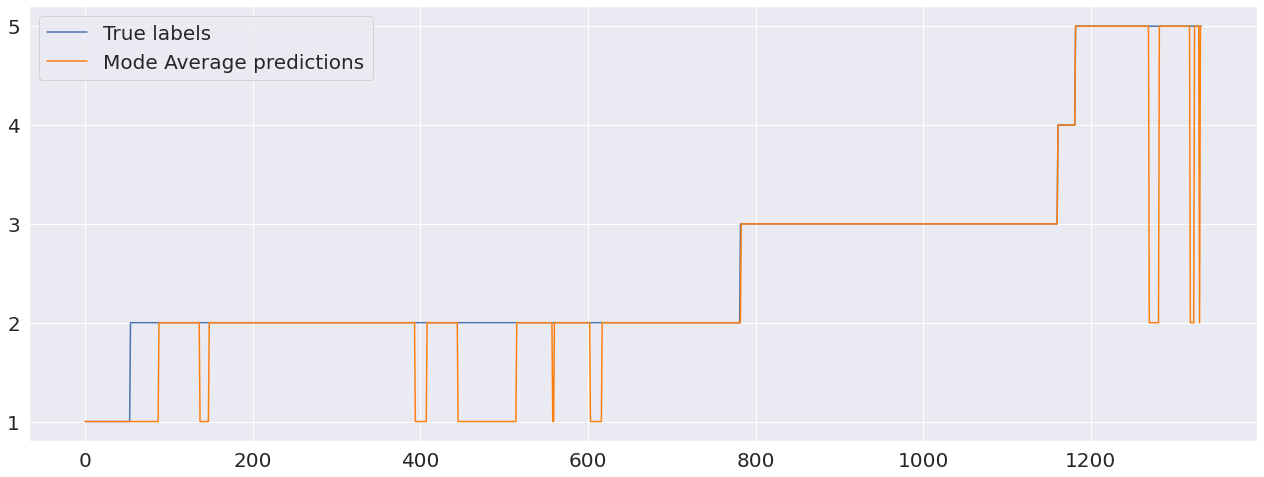

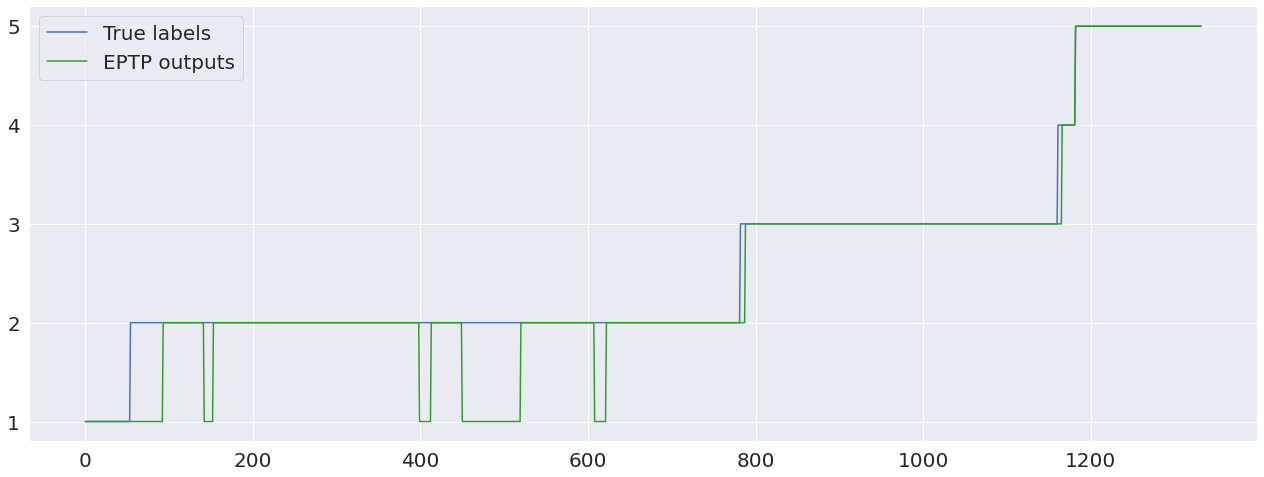

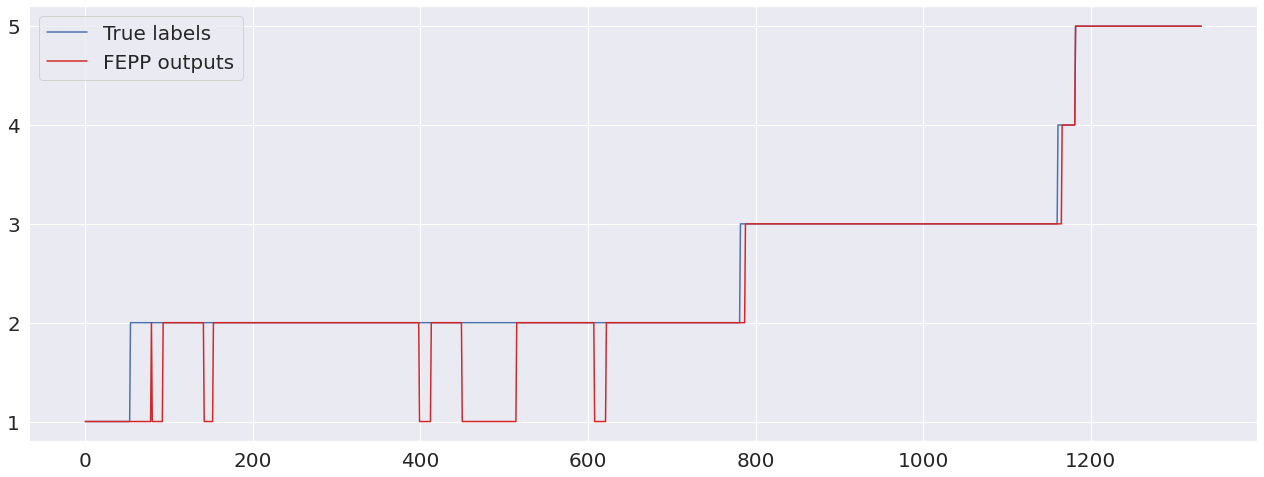

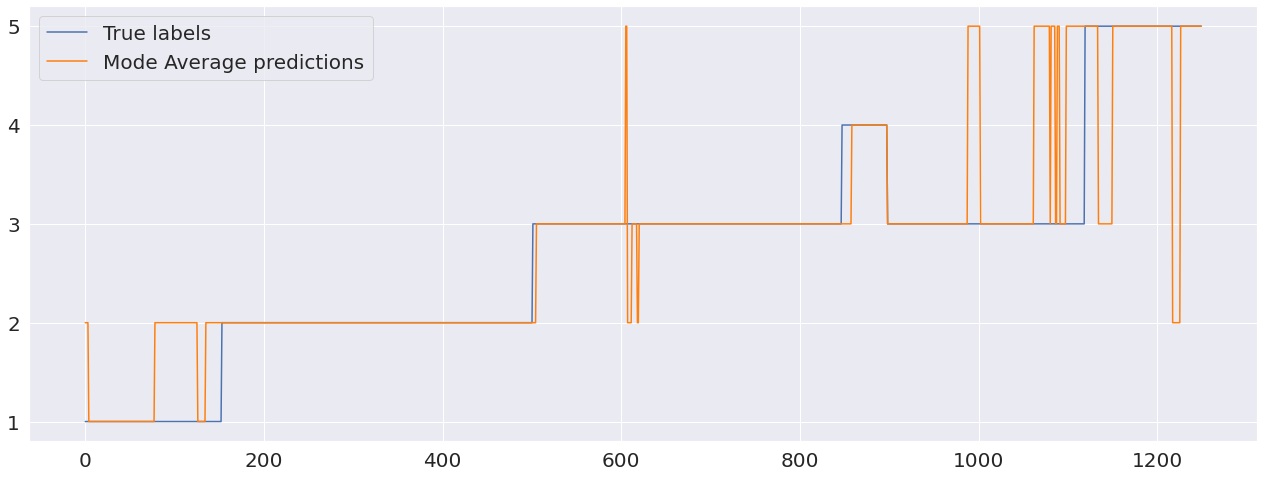

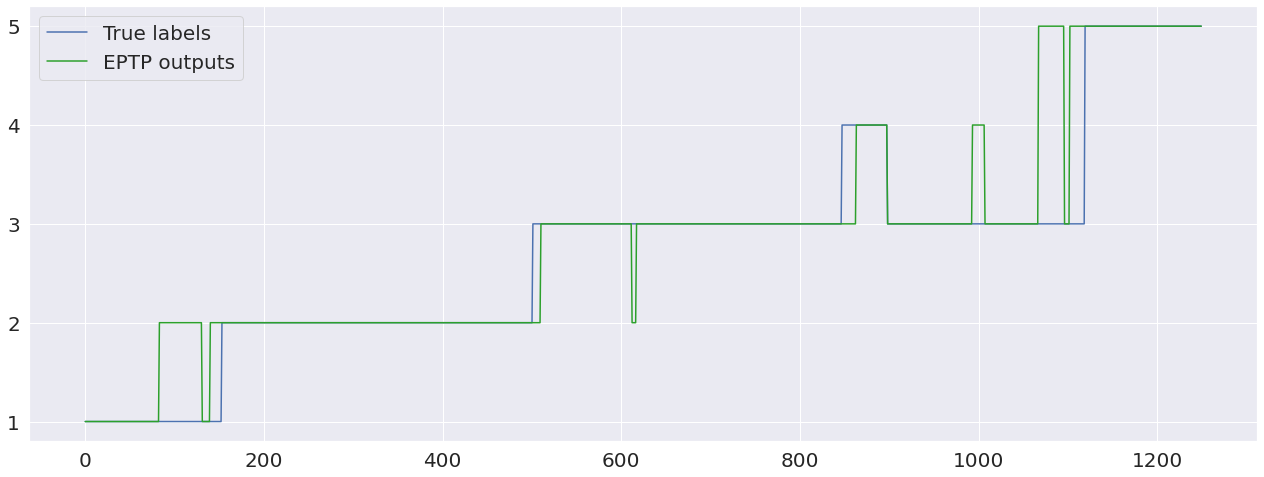

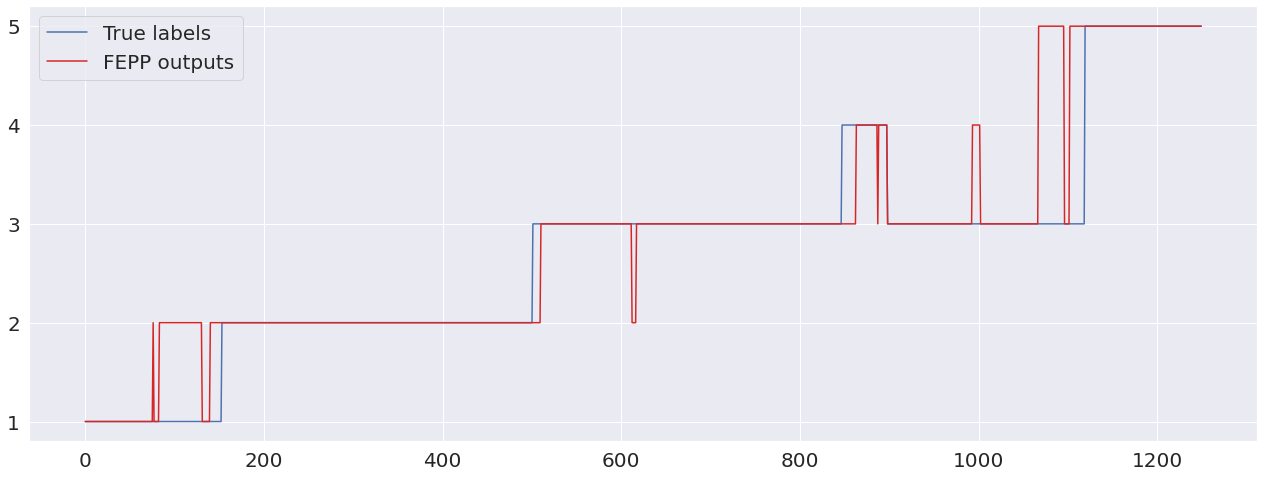

In [164]:
# plot original seq outputs and model outputs on seq results
for i in range(1,2):
    print("Video testing fold {}".format(i))
    video_arr = test_folds[6]
    for video in video_arr:
        y_true = true_label_no_zero[video]
        ma_pred = ma_pred_no_zero_dict[video]
        ma_pred = list(map(int, ma_pred))
        plotMAPred(ma_pred, y_true, 3)
        for model in ["eptp", "fepp"]:
            y_model = ma_pki_no_zero_dict[model][video]
            y_model = list(map(int, y_model))
            plotOutput(model, y_model, y_true, 3)